# NMFk: Feature extraction

<div style="text-align: left; padding-top: 30px; padding-bottom: 30px;">
    <img src="https://raw.githubusercontent.com/SmartTensors/NMFk.jl/master/logo/nmfk-logo.png" alt="NMFk" width=20% max-width=125px;/>
</div>

**NMFk** is a code within our award winning [SmartTensors](https://github.com/SmartTensors) framework for unsupervised, supervised and physics-informed (scientific) machine learning (ML) and artificial intelligence (AI) ([web](https:///SmartTensors.com) [source](https://github.com/SmartTensors)).

<div style="text-align: left; padding-top: 30px; padding-bottom: 30px;">
    <img src="https://raw.githubusercontent.com/SmartTensors/NMFk.jl/master/logo/SmartTensorsNewSmall.png" alt="NMFk" width=20% max-width=125px;/>
</div>

**NMFk** performs Nonnegative Matrix Factorization with $k$-means clustering

An example problem demonstrating how **NMFk** can be applied to extract and classify features and sensors observing these mixed features.

This type of analysis is related to the **blind source separation** problem.

Applying **NMFk**, we can automatically:

- identify the number of the unknown mixed signatures in a dataset 
- estimate the shape of the unknown mixed signatures
- estimate how the signatures are mixed at each sensor
- classify sensors based on how they observe (are impacted) the extracted features.

## Installation

If **NMFk** is not installed, first execute in the Julia REPL:

```julia
import Pkg
Pkg.add("NMFk")
Pkg.add("Mads")
Pkg.add("Cairo")
Pkg.add("Fontconfig")
Pkg.add("Gadfly")
```

In [1]:
Pkg.activate()
import NMFk
import Mads
import Random
import Cairo
import Fontconfig
import Gadfly

## Problem setup

Let us generate 4 random signals with legnth of 100 (this can be considered as 100 ):

In [2]:
Random.seed!(2021)

s1 = (sin.(0.05:0.05:5) .+1) ./ 2
s2 = (sin.(0.3:0.3:30) .+ 1) ./ 2
s3 = (sin.(0.5:0.5:50) .+ 1) ./ 2
s4 = rand(100)
W = [s1 s2 s3 s4]

100×4 Matrix{Float64}:
 0.52499      0.64776     0.739713    0.405796
 0.549917     0.782321    0.920735    0.0657738
 0.574719     0.891663    0.998747    0.398162
 0.599335     0.96602     0.954649    0.163816
 0.623702     0.998747    0.799236    0.783094
 0.64776      0.986924    0.57056     0.134115
 0.671449     0.931605    0.324608    0.883121
 0.694709     0.837732    0.121599    0.386875
 0.717483     0.71369     0.0112349   0.242105
 0.739713     0.57056     0.0205379   0.131588
 ⋮                                    
 0.0031545    0.812189    0.950894    0.130975
 0.000972781  0.682826    0.792098    0.381099
 3.83712e-5   0.537133    0.561787    0.89211
 0.000353606  0.388122    0.316347    0.18814
 0.0019177    0.249105    0.115873    0.695555
 0.00472673   0.1325      0.00944578  0.462331
 0.00877369   0.0487227   0.0231237   0.574861
 0.0140485    0.00525646  0.153558    0.0919372
 0.0205379    0.00598419  0.368813    0.710313

The singals look like this:

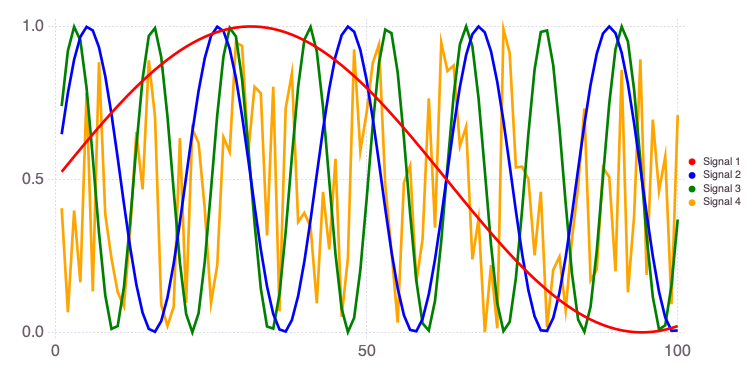

In [3]:
Mads.plotseries(W)

Now we can mix the signals in matrix `W` to produce a data matrix `X` representing data collected at 10 sensors (e.g., measurement devices or wells at different locations).

Each of the 10 sensors is observing some mixture of the 4 signals in `W`.

The way the 4 signals are mixed at the sensors is represented by the mixing matrix `H`.

Let us define the mixing matrix `H` as:

In [4]:
H = [1 5 0 0 1 1 2 1 0 2; 0 1 1 5 2 1 0 0 2 3; 3 0 0 1 0 1 0 5 4 3; 1 1 4 1 5 0 1 1 5 3]

4×10 Matrix{Int64}:
 1  5  0  0  1  1  2  1  0  2
 0  1  1  5  2  1  0  0  2  3
 3  0  0  1  0  1  0  5  4  3
 1  1  4  1  5  0  1  1  5  3

Each column of the `H` matrix defines how the 3 signals are represented in each sensors.

For example, the first sensor (column 1 above) detects only Signals 1 and 3; Signal 2 is missing because `H[2,1]` is equal to zero.

The second sensor (column 2 above) detects Signals 1, 2 and 4; Signal 3 is missing because `H[3,2]` is equal to zero.

The entries of `H` matrix also define the proportions at which the signals are mixed.

For example, the first sensor (column 1 above) detects Signal 3 times stronger than Signals 1 and 4.

The data matrix `X` is formed by multiplying `W` and `H` matrices. `X` defines the actual data observed.

In [5]:
X = W * H

100×10 Matrix{Float64}:
 3.14992   3.6785    2.27095   4.38431   …  4.62935   6.28335  6.42979
 3.3779    3.59768   1.04542   4.89812      5.21937   5.57645  6.40633
 3.96912   4.16342   2.48431   5.85523      5.96662   7.76913  8.01516
 3.6271    4.12651   1.62128   5.94856      5.53639   6.56971  7.45212
 3.8045    4.90035   4.13112   6.57607      5.40298   9.10991  8.99064
 2.49356   4.35984   1.52339   5.63929   …  3.63468   4.92666  6.37032
 2.52839   5.17197   4.46409   5.86575      3.17761   7.57725  7.7609
 1.44638   4.69815   2.38523   4.69713      1.68958   4.09623  5.42803
 0.993292  4.54321   1.68211   3.82179      1.01576   2.68284  4.33605
 0.932914  4.40071   1.09691   3.00493      0.97399   1.88121  3.64748
 ⋮                                       ⋱                     
 2.98681   0.958936  1.33609   5.14281      4.8886    6.08283  5.68848
 2.75837   1.06879   2.20722   4.58733      4.34256   6.43954  5.57002
 2.57751   1.42943   4.10557   4.13956      3.70108   7.78196

The data matrix `X` looks like this:

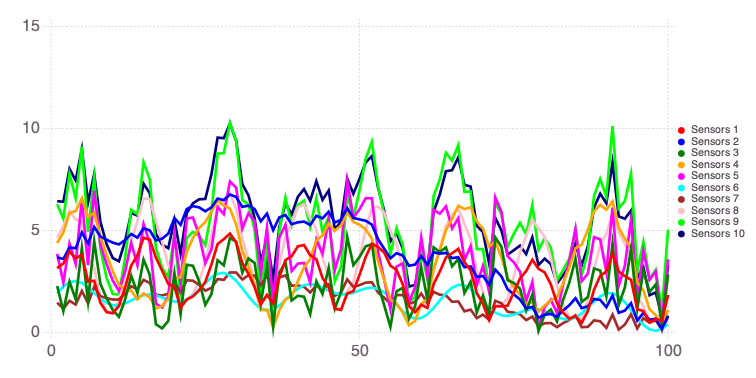

In [6]:
Mads.plotseries(X; name="Sensors")

## Execution

Now, we can assume that we only know the data matrix `X` and the `W` and `H` matrices are unknown.

We can execute **NMFk** and analyze the data matrix `X`.

**NMFk** will automatically:

- identify the number of the unknown mixed signals in `X` 
- estimate the shape of the unknown mixed signals (i.e., estimate the entries of `W` matrix)
- estimate how the signals are mixed at the 5 sensors (i.e., estimate the entries of `H` matrix)

This can be done based only on the information in `X`:

In [7]:
nkrange=2:10
We, He, fitquality, robustness, aic, kopt = NMFk.execute(X, nkrange; save=false, method=:simple);


OF: min 563.4561839705091 max 571.0956047569299 mean 566.1096913459744 std 2.5162024019835187


Worst correlation by columns: 0.204840178904257


Worst correlation by rows: 0.6730840865506231
Worst covariance by columns: 0.07619556361296793


Worst covariance by rows: 0.3177632870362544
Worst norm by columns: 0.2062783776100441


Worst norm by rows: 0.5879052371885953
Signals:  2 Fit:     563.4562 Silhouette:    0.9961238 AIC:    -133.6657 Signal order: [1, 2]

OF: min 205.10453576810346 max 205.44013709359942 mean 205.2558183299092 std 0.10764194146505947
Worst correlation by columns: 0.765756624884207
Worst correlation by rows: 0.8221459244824038
Worst covariance by columns: 0.09620742799039032
Worst covariance by rows: 0.3340068356918061
Worst norm by columns: 0.20481267664903935
Worst norm by rows: 0.7412498027521249
Signals:  3 Fit:     205.1045 Silhouette:    0.9877389 AIC:    -924.2355 Signal order: [3, 2, 1]



OF: min 0.02606110346539826 max 0.3285930894206071 mean 0.08570976712343938 std 0.09054762017310256
Worst correlation by columns: 0.9998437470148135
Worst correlation by rows: 0.9999635107298314
Worst covariance by columns: 0.11034854993765787
Worst covariance by rows: 0.41019527264737216
Worst norm by columns: 0.6303363471078243
Worst norm by rows: 0.5079941550602866
Signals:  4 Fit:    0.0260611 Silhouette:    0.9951292 AIC:    -9675.067 Signal order: [4, 3, 2, 1]



OF: min 0.019296683745481904 max 0.1313755817852479 mean 0.05983435689746689 std 0.03358572465839549
Worst correlation by columns: 0.9999051870218388
Worst correlation by rows: 0.9999840409655578
Worst covariance by columns: 0.11049073449732591
Worst covariance by rows: 0.41076142701552415
Worst norm by columns: 0.6614805465202735
Worst norm by rows: 0.5400392690140969
Signals:  5 Fit:   0.01929668 Silhouette:   -0.6128532 AIC:    -9755.577 Signal order: [5, 3, 4, 1, 2]



OF: min 0.006752373216074524 max 0.20286975450972983 mean 0.04849374109403328 std 0.05784790835383283
Worst correlation by columns: 0.9999482835876661
Worst correlation by rows: 0.9999956205669132
Worst covariance by columns: 0.11043103874232613
Worst covariance by rows: 0.41155827502729214
Worst norm by columns: 0.8228221042701841
Worst norm by rows: 0.5518600983174698
Signals:  6 Fit:  0.006752373 Silhouette:    -0.612744 AIC:    -10585.62 Signal order: [4, 3, 1, 5, 6, 2]



OF: min 0.0062303074161237084 max 0.04561774488510166 mean 0.021946059024547167 std 0.015762068323271657
Worst correlation by columns: 0.999994988539508
Worst correlation by rows: 0.9999881902662511
Worst covariance by columns: 0.11044002227515037
Worst covariance by rows: 0.4118196452194747
Worst norm by columns: 0.3372663940462135
Worst norm by rows: 0.4914608900380674
Signals:  7 Fit:  0.006230307 Silhouette:   -0.7747081 AIC:    -10446.08 Signal order: [6, 3, 4, 7, 2, 1, 5]



OF: min 0.0042567264451076345 max 0.04851942247626621 mean 0.02038527154156753 std 0.01431645314970248
Worst correlation by columns: 0.9999933466928541
Worst correlation by rows: 0.9999944996671574
Worst covariance by columns: 0.11043873478859806
Worst covariance by rows: 0.41165807364380347
Worst norm by columns: 0.2545539225774592
Worst norm by rows: 0.6718079734504087
Signals:  8 Fit:  0.004256726 Silhouette:   -0.6025868 AIC:    -10607.01 Signal order: [6, 8, 2, 4, 1, 7, 5, 3]



OF: min 0.009267875446144248 max 0.046369482106464036 mean 0.022308192866677068 std 0.012614940493108956
Worst correlation by columns: 0.9999818984769164
Worst correlation by rows: 0.9999732994493604
Worst covariance by columns: 0.11042200672761357
Worst covariance by rows: 0.4118426897347687
Worst norm by columns: 0.35746086744005723
Worst norm by rows: 0.5555803324415174
Signals:  9 Fit:  0.009267875 Silhouette:   -0.5954714 AIC:    -9608.956 Signal order: [2, 6, 3, 7, 1, 9, 8, 4, 5]



OF: min 0.00495255180583985 max 0.018638566799673423 mean 0.012368759426061797 std 0.004788607734740136
Worst correlation by columns: 0.9999939099851183
Worst correlation by rows: 0.9999949650207964
Worst covariance by columns: 0.11040647577170468
Worst covariance by rows: 0.4117908021372535
Worst norm by columns: 0.2926290979379814
Worst norm by rows: 0.6303501719023523
Signals: 10 Fit:  0.004952552 Silhouette:   -0.6026156 AIC:    -10015.61 Signal order: [1, 7, 9, 3, 2, 10, 6, 4, 5, 8]
Signals:  2 Fit:     563.4562 Silhouette:    0.9961238 AIC:    -133.6657
Signals:  3 Fit:     205.1045 Silhouette:    0.9877389 AIC:    -924.2355
Signals:  4 Fit:    0.0260611 Silhouette:    0.9951292 AIC:    -9675.067
Signals:  5 Fit:   0.01929668 Silhouette:   -0.6128532 AIC:    -9755.577
Signals:  6 Fit:  0.006752373 Silhouette:    -0.612744 AIC:    -10585.62
Signals:  7 Fit:  0.006230307 Silhouette:   -0.7747081 AIC:    -10446.08
Signals:  8 Fit:  0.004256726 Silhouette:   -0.6025868 AIC:    -1060

┌ Info: Results
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:15
┌ Info: Optimal solution: 4 signals
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkExecute.jl:23


## Results

**NMFk** returns the estimated optimal number of signals `kopt` which in this case, as expected, is equal to 4.

A plot of the fit and the robustness is shown below:

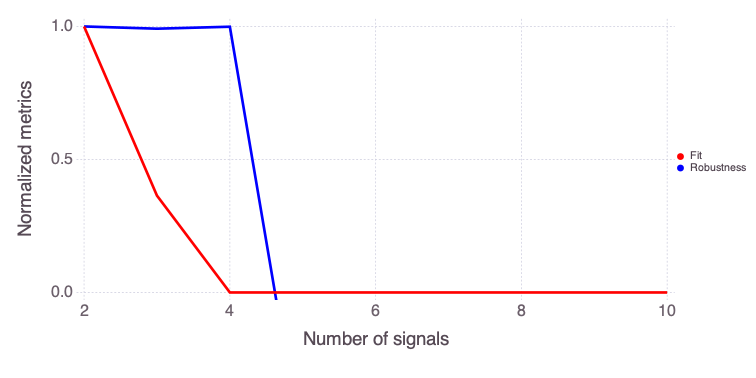

In [8]:
NMFk.plot_feature_selecton(nkrange, fitquality, robustness)

Acceptable (underfitting) solutions:

In [9]:
NMFk.getks(nkrange, robustness[nkrange])

3-element Vector{Int64}:
 2
 3
 4

**NMFk** also returns estimates of matrices `W` and `H`.

Here the estimates of matrices W and H are stored as `We` and `He` objects.

`We[kopt]` and `He[kopt]` are scaled versions of the original `W` and `H` matrices:

In [10]:
We[kopt]

100×4 Matrix{Float64}:
  8.35984   12.8513     9.8499     6.98288
  0.882809  15.9778    11.8127     7.30996
  8.08025   17.3301    13.5455     7.62872
  2.98001   16.5393    14.6198     7.97546
 16.4947    13.8386    15.2631     8.30801
  2.43144    9.82891   14.9337     8.6807
 18.8057     5.57065   14.2667     9.00687
  8.06176    2.03126   12.7232     9.35944
  4.94977    0.115306  10.7992     9.68569
  2.53534    0.315878   8.59067    9.97687
  ⋮                                
  2.44801   16.4477    12.3748     3.18961e-15
  7.95672   13.7045    10.4437     3.61166e-11
 19.1721     9.71597    8.34621    2.1087e-7
  3.95505    5.44963    5.93872    3.1738e-8
 15.1073     1.98462    3.94022    0.00145974
 10.0749     0.145647   2.11313    0.0470913
 12.5492     0.395428   0.858563   0.0817772
  1.94723    2.68436    0.0975339  0.165447
 15.3501     6.4465     0.260951   0.19591

In [11]:
He[kopt]

4×10 Matrix{Float64}:
 0.0457141   0.0456666   0.183246    …  0.0455059  0.227846    0.135591
 0.173145    0.00390684  0.003374       0.28775    0.233158    0.175627
 0.00244652  0.0645862   0.066335       0.0039405  0.135276    0.19962
 0.0743214   0.373864    0.00599197     0.0734625  0.00697259  0.153705

The extracted signals are ordered by their expected importance.

The most dominant is the first signal, which is captured by Column 1 of `We[kopt]` and Row 1 of `He[kopt]`.

The least dominant is the third (last) signal, which is captured by Column 3 of `We[kopt]` and Row 3 of `He[kopt]`.

Note that the order of columns ('signals') in `W` and `We[kopt]` are not expected to match.

In the same way, the order of rows ('sensors') in `H` and `He[kopt]` are also not expected to match.

In general, the estimated order of 'signals' may be slightly different every time the code is executed due to randomness of the processes.

Below are plots providing comparisons between the original and estimated `W` an `H` matrices.


A plot of the original signals:

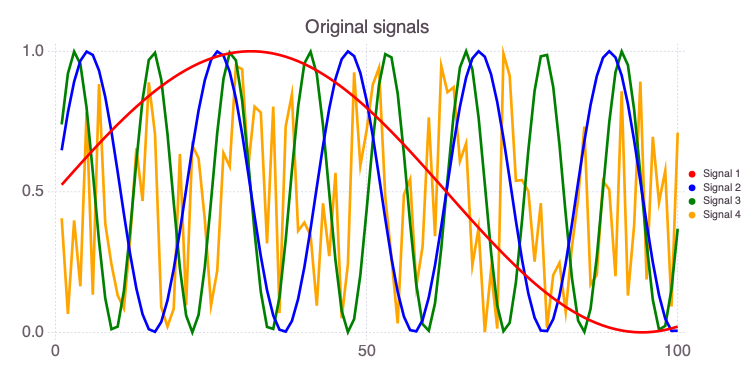

In [12]:
Mads.plotseries(W; title="Original signals")

A plot of the reconstructed signals:

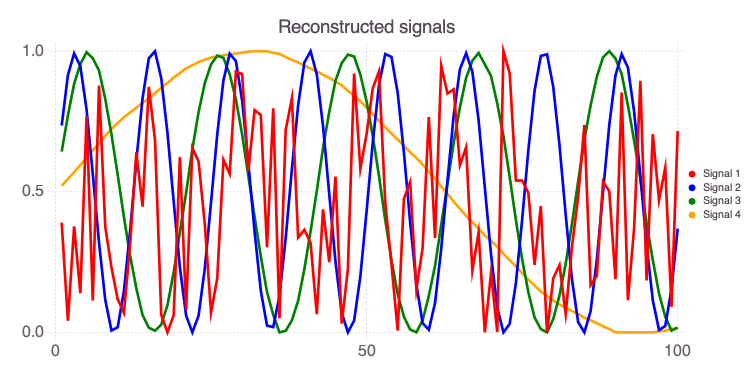

In [13]:
Mads.plotseries(We[kopt] ./ maximum(We[kopt]; dims=1); title="Reconstructed signals")

A plot of the original mixing matrix:

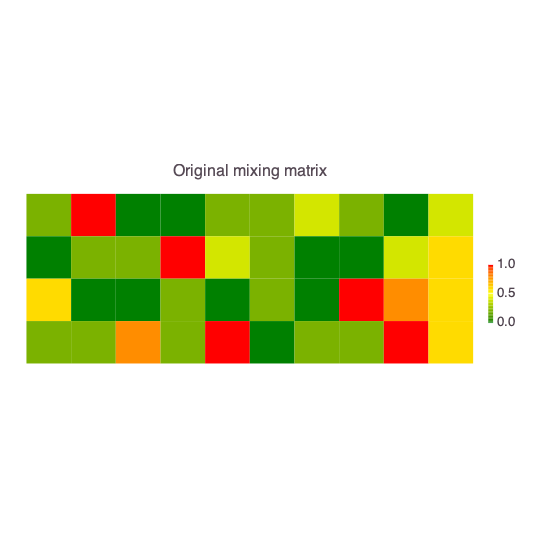

In [14]:
NMFk.plotmatrix(H ./ maximum(H; dims=2); title="Original mixing matrix")

A plot of the reconstructed mixing matrix:

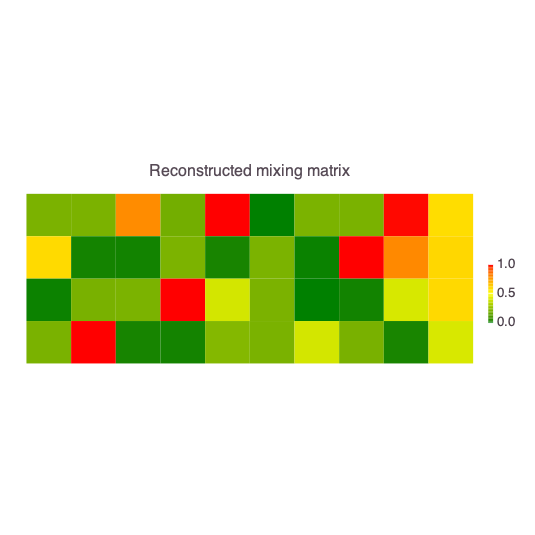

In [15]:
NMFk.plotmatrix(He[kopt] ./ maximum(He[kopt]; dims=2); title="Reconstructed mixing matrix")

Figures above demonstrate the accurate reconstruction of the original `W` and `H` matrices.

**NMFk** results can be further analyzed as demonstrated below:

┌ Info: Number of signals: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:205
┌ Info: Sensors (signals=2)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:209


┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Hmatrix-2-2_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67


┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Wmatrix-2-2_100-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Info: Signal B -> A Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:316


2×2 Matrix{Any}:
 "s2"  0.816528
 "s7"  0.34415

┌ Info: Signal A -> B Count: 8
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:316
┌ Info: Signal A (S1) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:333


8×2 Matrix{Any}:
 "s8"   1.0
 "s9"   0.765652
 "s10"  0.664984
 "s1"   0.620243
 "s6"   0.235877
 "s4"   0.183688
 "s5"   0.0471445
 "s3"   0.00955952

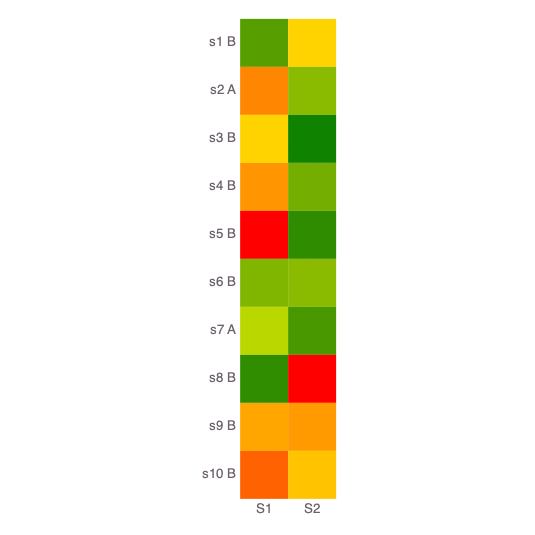

┌ Info: Signal B (S2) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:333


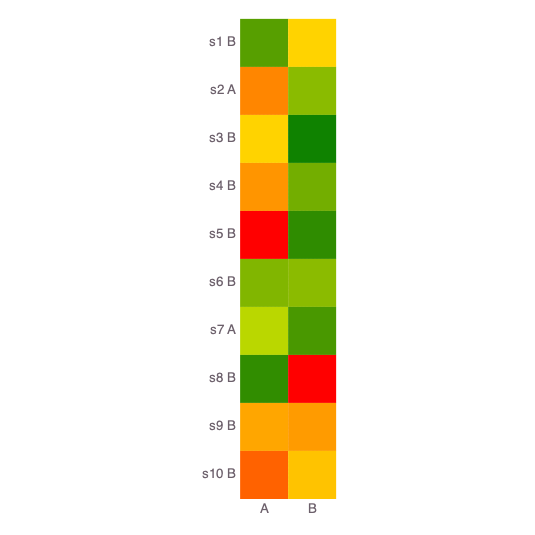

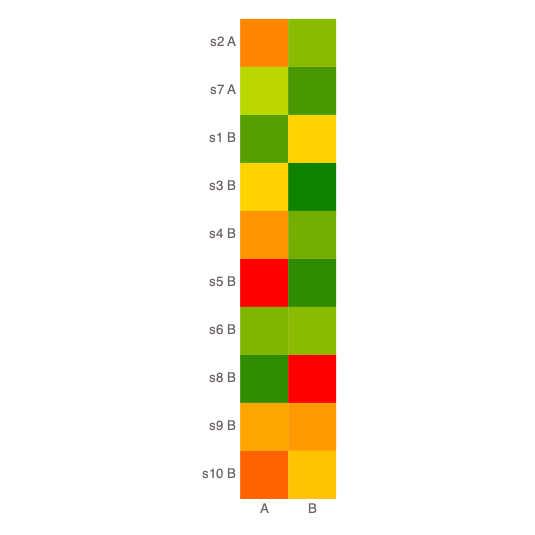

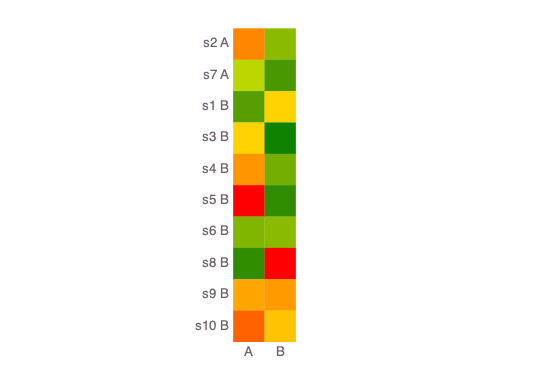

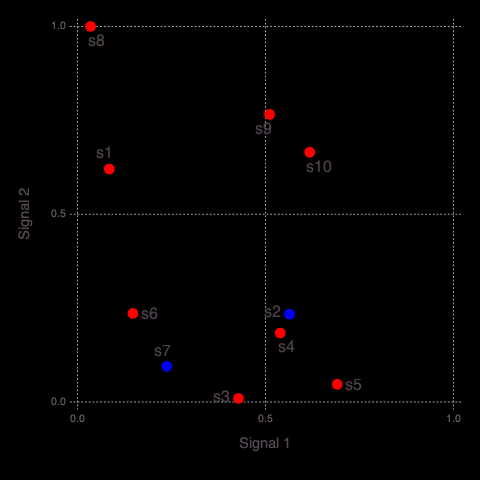

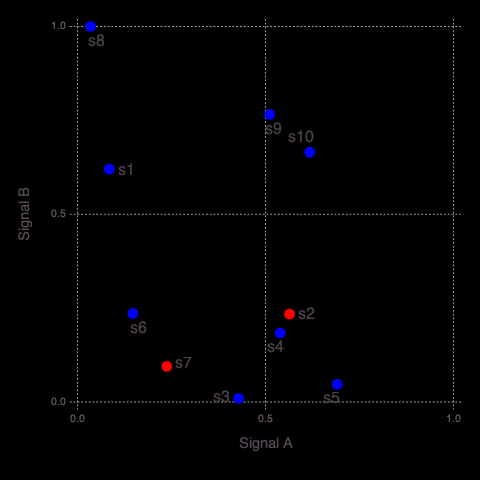

36×2 Matrix{Float64}:
 48.0  1.0
  7.0  0.90646
 50.0  0.811182
 23.0  0.80957
 49.0  0.80668
 45.0  0.799657
 72.0  0.792193
 22.0  0.781473
 32.0  0.75111
 24.0  0.738339
  ⋮    
 34.0  0.437807
 12.0  0.422768
 57.0  0.397088
 61.0  0.3737
 11.0  0.36556
 59.0  0.298814
 19.0  0.298337
 36.0  0.257546
 58.0  0.214994

┌ Info: Times (signals=2)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:391
┌ Info: Signal A (S2) Count: 64
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal B (S1) Count: 36
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal B -> A Count: 36
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal A -> B Count: 64
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:429


64×2 Matrix{Float64}:
 29.0  1.0
 28.0  0.994387
 41.0  0.966333
 16.0  0.954458
 15.0  0.947798
 40.0  0.932646
 53.0  0.932094
 27.0  0.923499
  3.0  0.920881
 66.0  0.916317
  ⋮    
 83.0  0.19494
 96.0  0.168447
 99.0  0.124341
 71.0  0.109416
 84.0  0.0915553
 85.0  0.0873578
 98.0  0.0869121
 86.0  0.0792189
 97.0  0.0621416

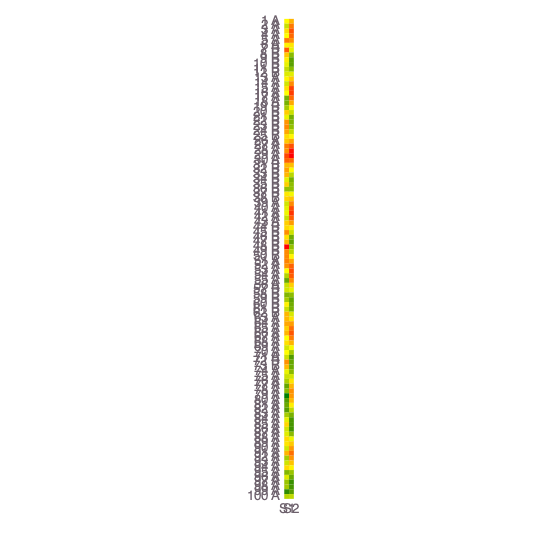

┌ Info: Signal B (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:429


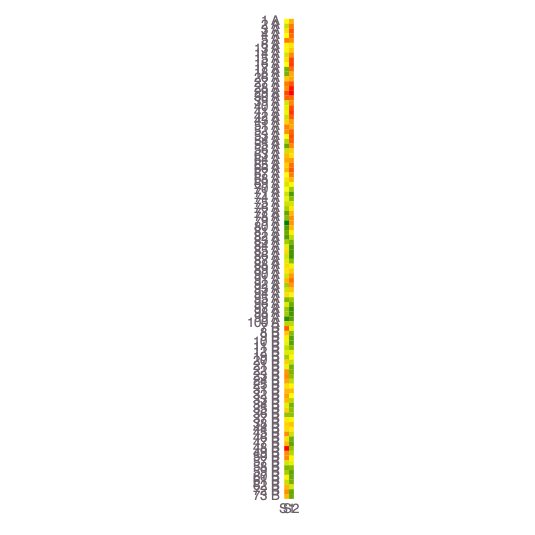

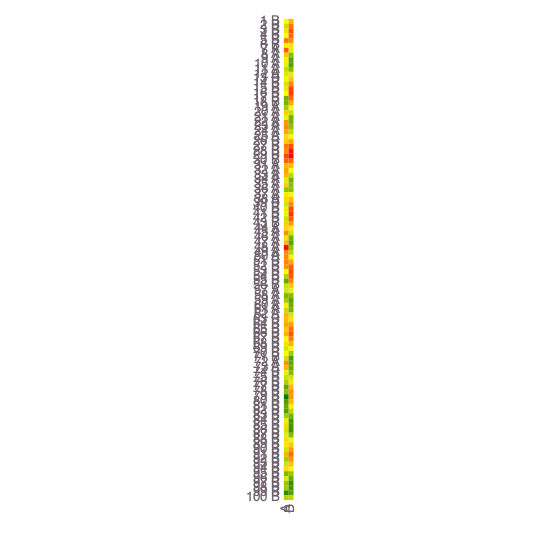

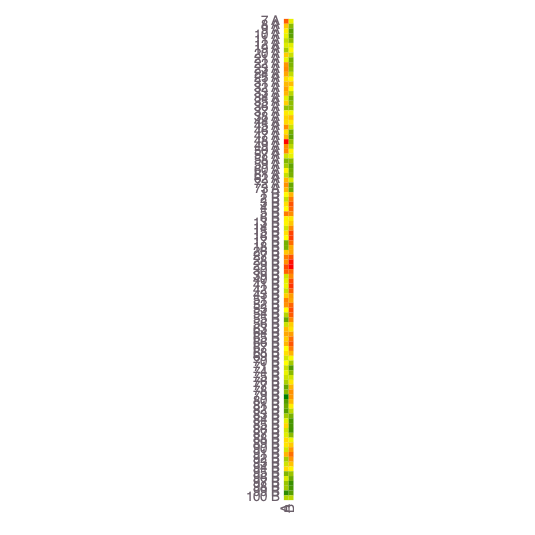

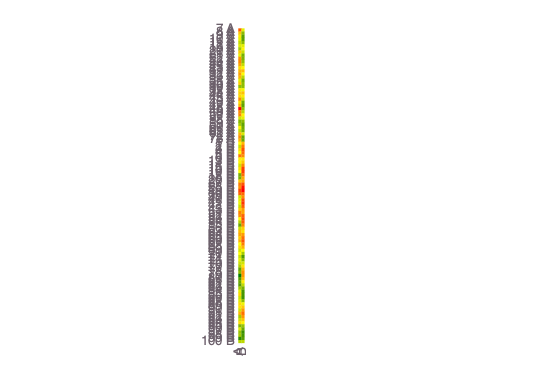

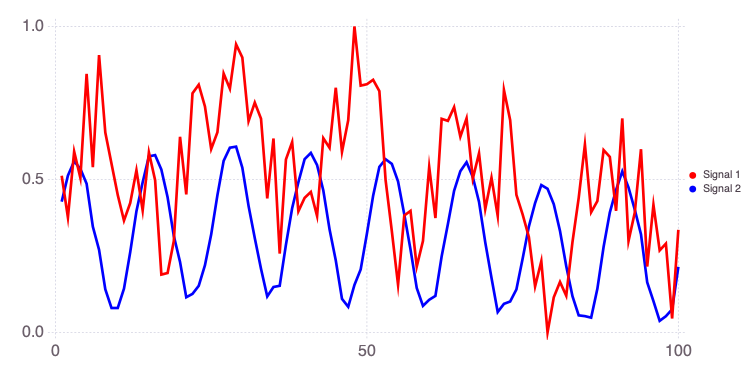

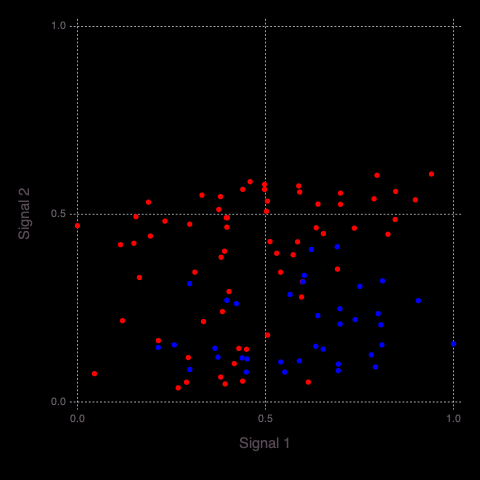

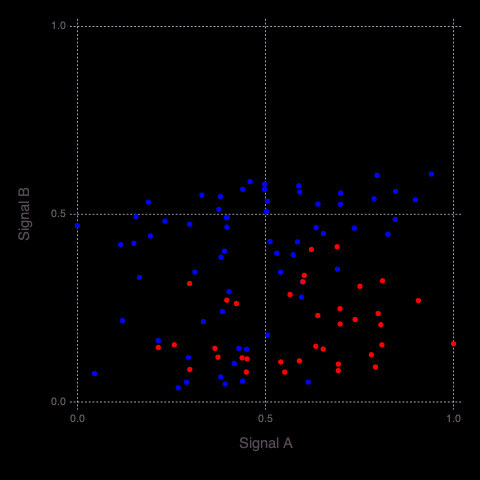

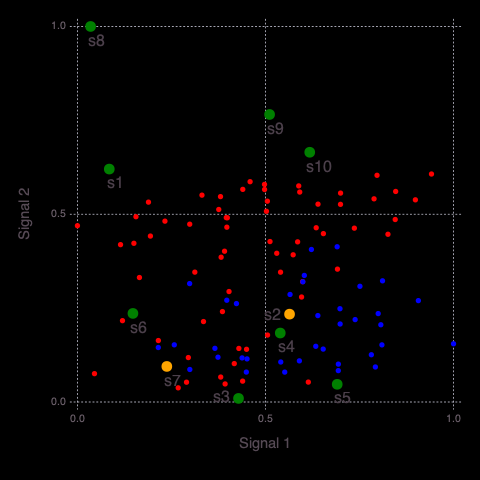

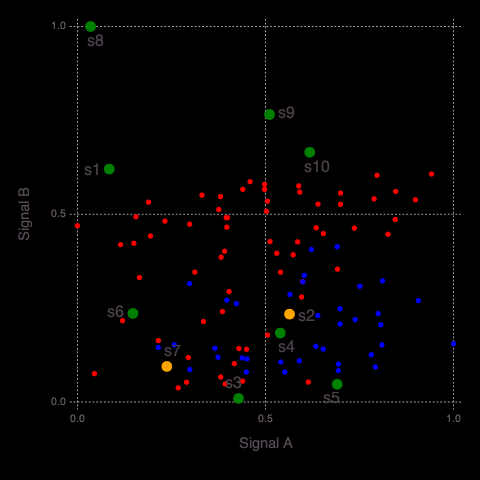

┌ Info: Number of signals: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:205
┌ Info: Sensors (signals=3)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:209
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Hmatrix-3-3_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float

3×2 Matrix{Any}:
 "s4"  0.961764
 "s5"  0.9239
 "s3"  0.675083

5×2 Matrix{Any}:
 "s8"   1.0
 "s9"   0.804147
 "s10"  0.642766
 "s1"   0.60861
 "s6"   0.221175

2×2 Matrix{Any}:
 "s2"  1.0
 "s7"  0.419145

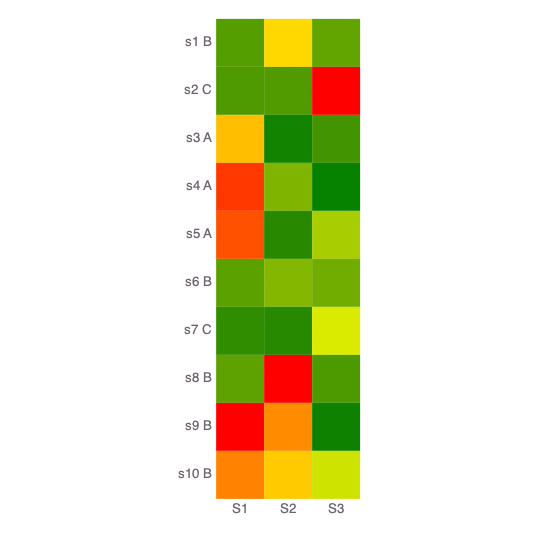

┌ Info: Robust k-means analysis results are loaded from file ./Wmatrix-3-3_100-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Info: Signal B -> A Count: 3
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:316
┌ Info: Signal A -> B Count: 5
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:316
┌ Info: Signal C -> C Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:316
┌ Info: Signal A (S1) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:333
┌ Info: Signal B (S2) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:333
┌ Info: Signal C (S3) (k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:333


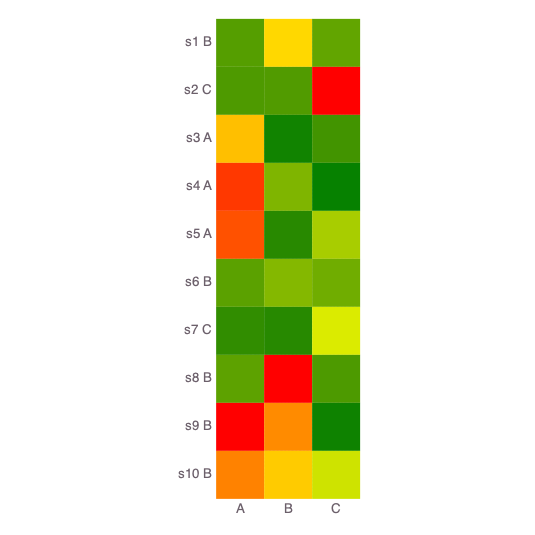

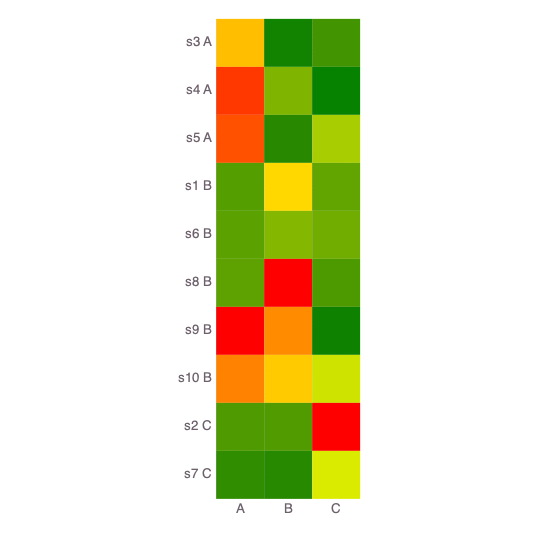

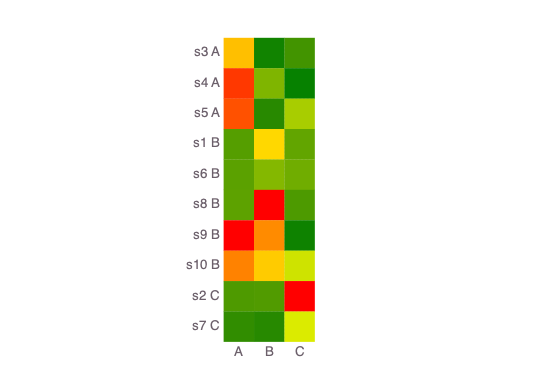

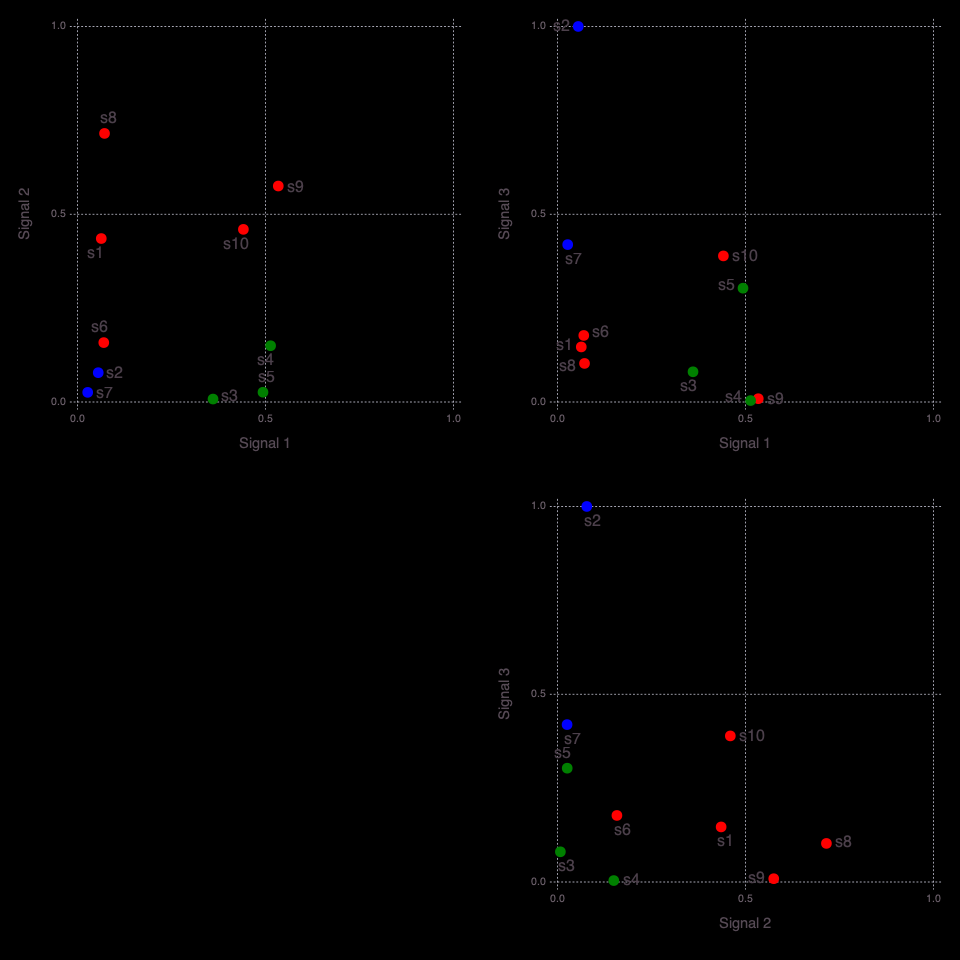

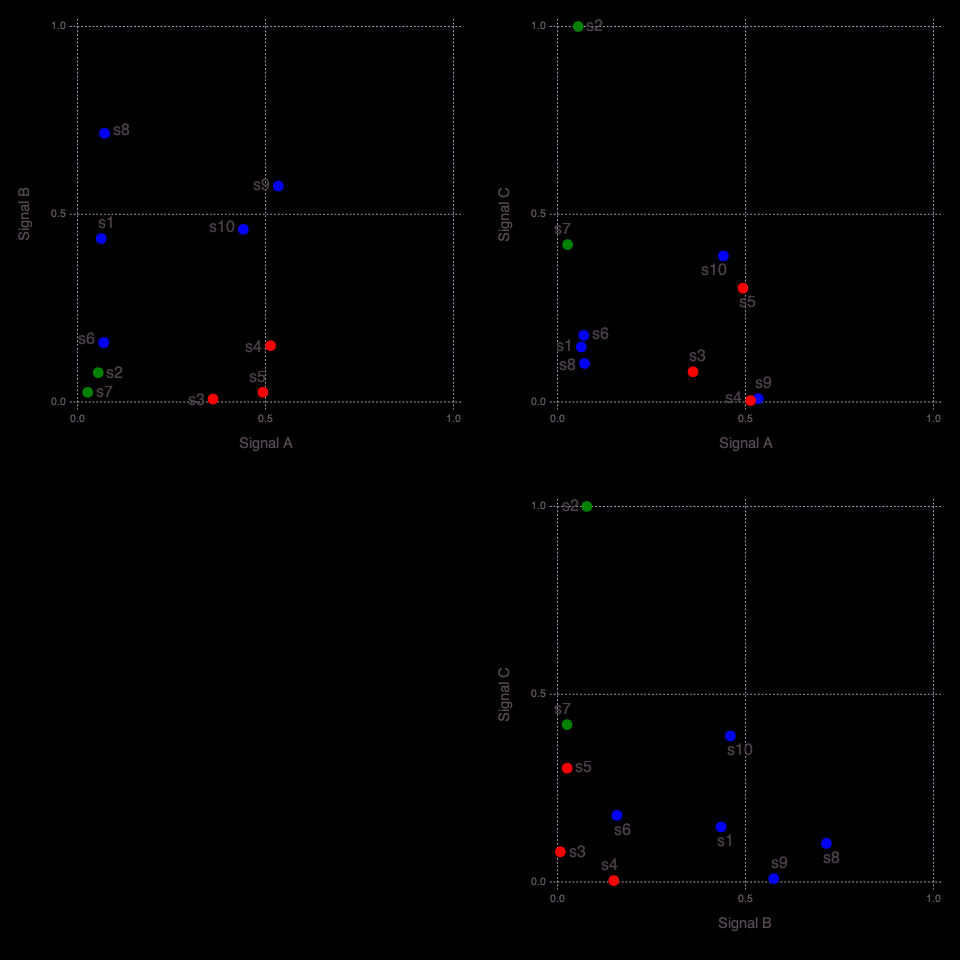

37×2 Matrix{Float64}:
 91.0  0.977447
  5.0  0.929754
 29.0  0.923258
 64.0  0.836318
 66.0  0.827266
 94.0  0.817911
 88.0  0.809029
 27.0  0.807474
 52.0  0.801024
 89.0  0.797584
  ⋮    
  2.0  0.366794
 95.0  0.303642
 78.0  0.294368
 54.0  0.240205
 42.0  0.237622
 81.0  0.212876
 82.0  0.151576
 99.0  0.061458
 79.0  0.0

23×2 Matrix{Float64}:
 41.0  1.0
 16.0  0.98127
 53.0  0.966055
 15.0  0.963061
 40.0  0.961342
 17.0  0.919987
 55.0  0.865718
 30.0  0.844847
 14.0  0.829076
 39.0  0.823647
  ⋮    
 56.0  0.642863
 31.0  0.642328
 13.0  0.638229
 38.0  0.638226
 19.0  0.516139
 57.0  0.42853
 37.0  0.424425
 58.0  0.221269
 34.0  0.127527

40×2 Matrix{Float64}:
 35.0  1.0
 33.0  0.999454
 32.0  0.993931
 23.0  0.970644
 22.0  0.965673
 48.0  0.936445
 24.0  0.930074
 20.0  0.903684
 45.0  0.893843
 25.0  0.852064
  ⋮    
 71.0  0.312965
 74.0  0.303642
 85.0  0.214224
 84.0  0.168959
 83.0  0.126965
 86.0  0.120085
 87.0  0.10552
 98.0  0.100582
 97.0  0.0865212

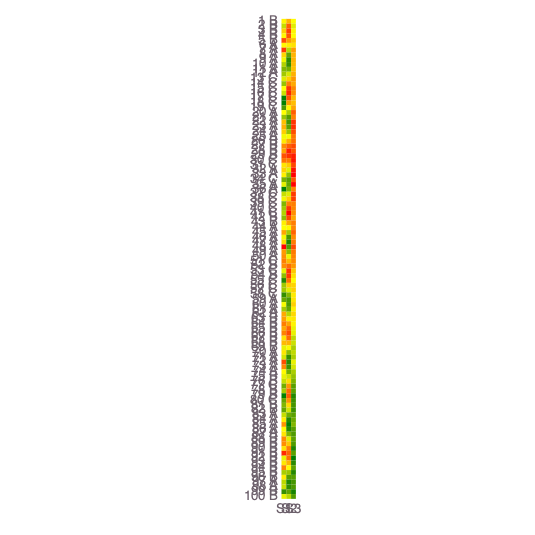

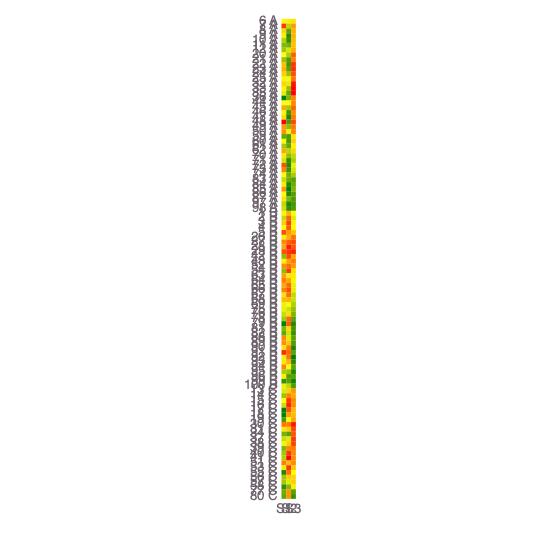

┌ Info: Times (signals=3)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:391
┌ Info: Signal A (S3) Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal B (S1) Count: 37
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal C (S2) Count: 23
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal B -> A Count: 37
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal C -> B Count: 23
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal A -> C Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:429
┌ Info: Signal B (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:429
┌ Info: Signal C (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:429


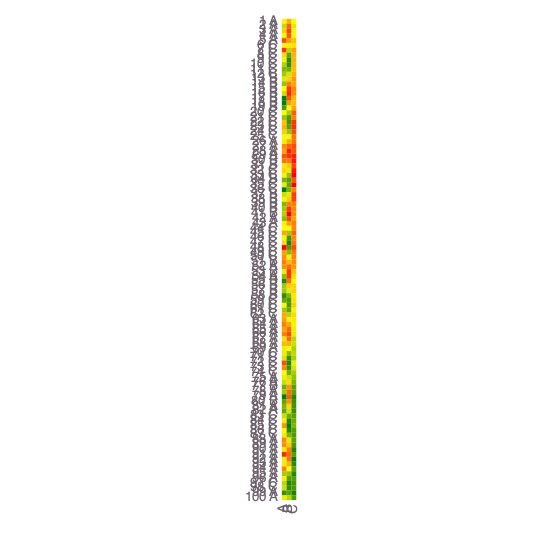

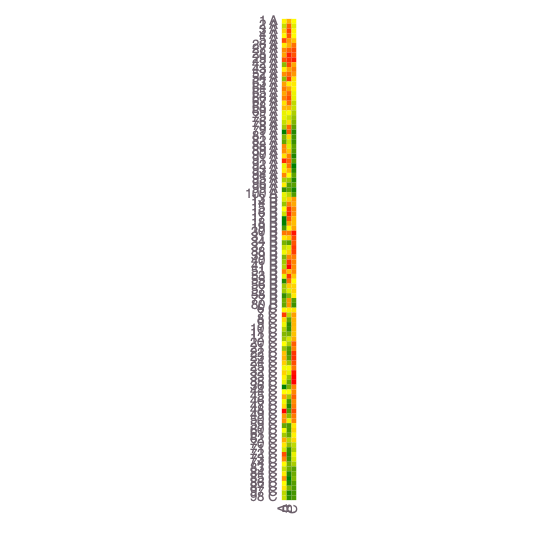

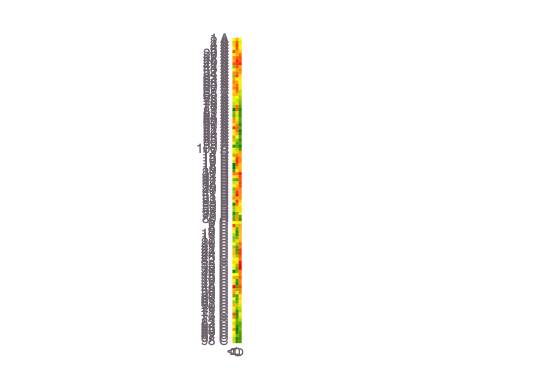

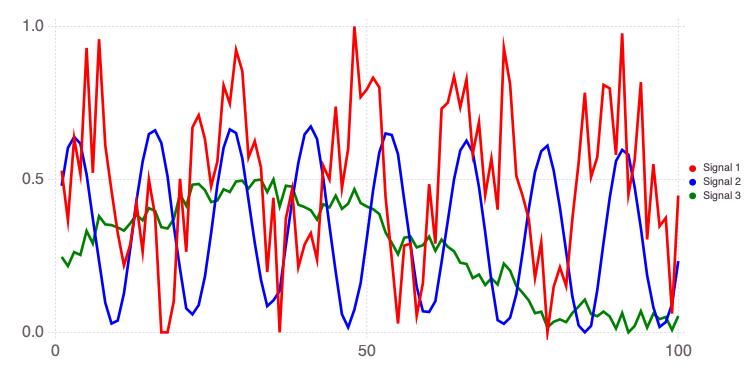

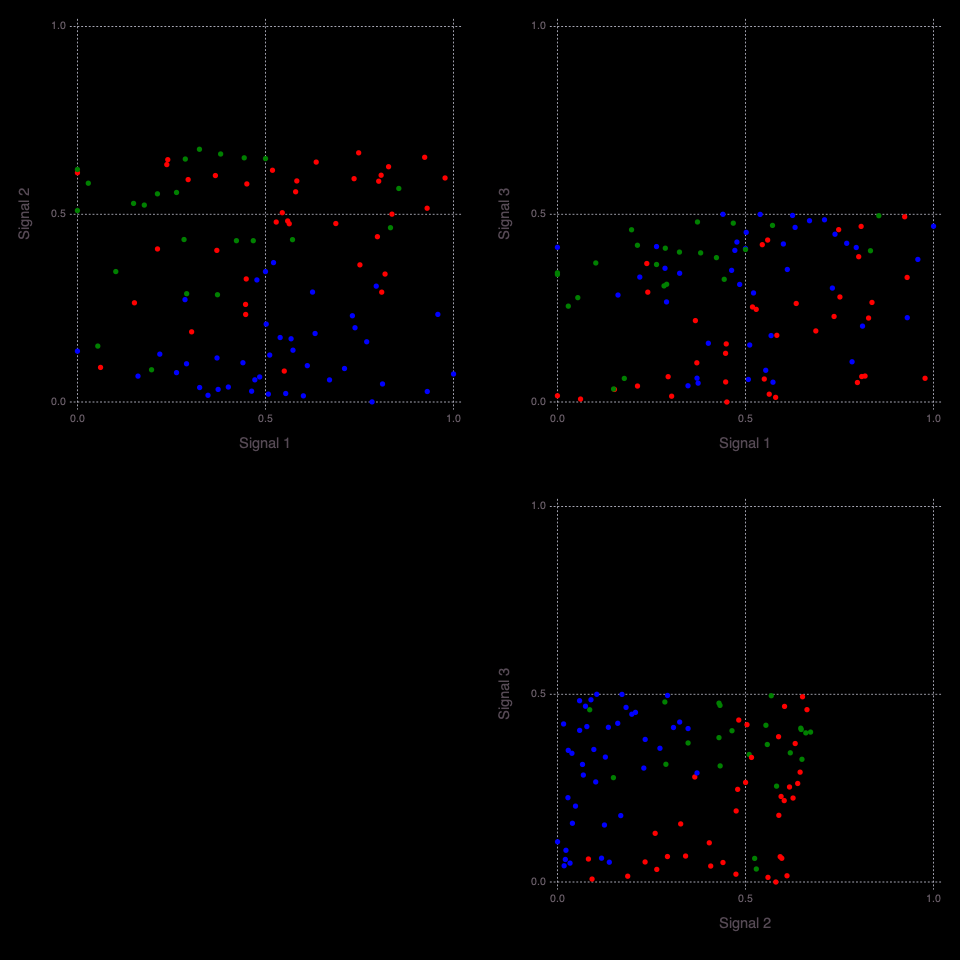

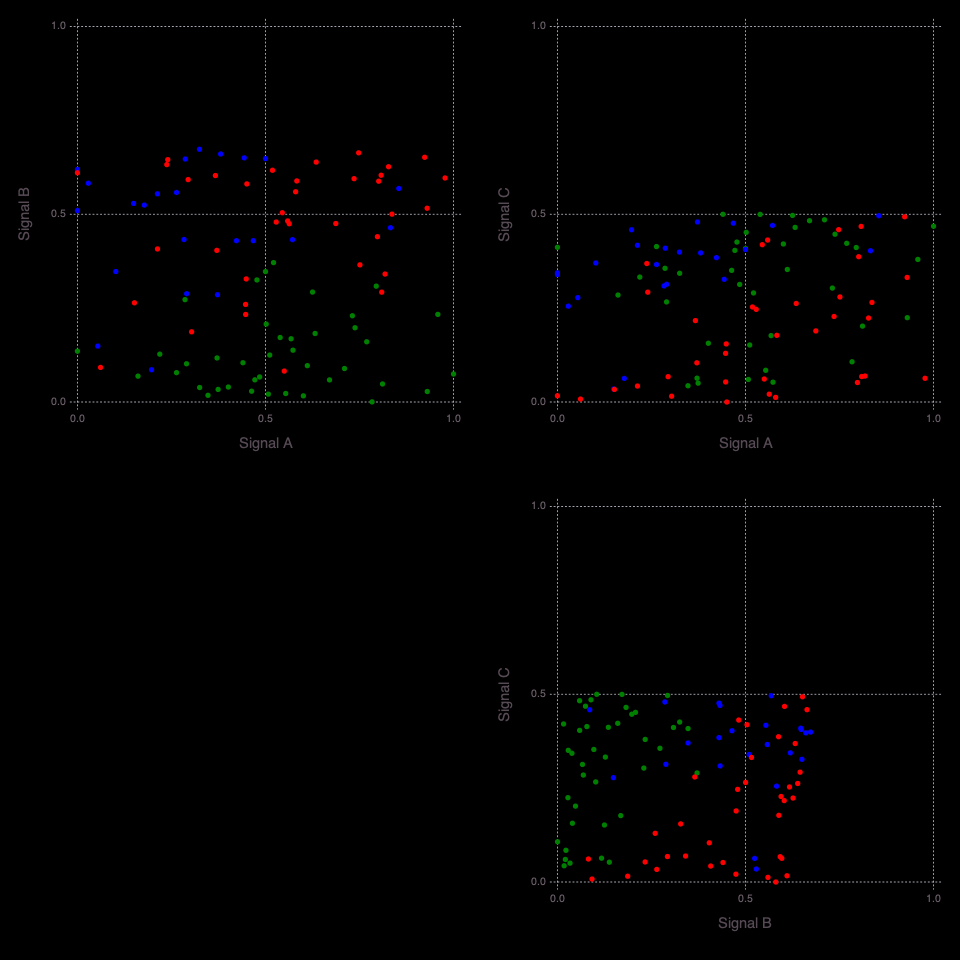

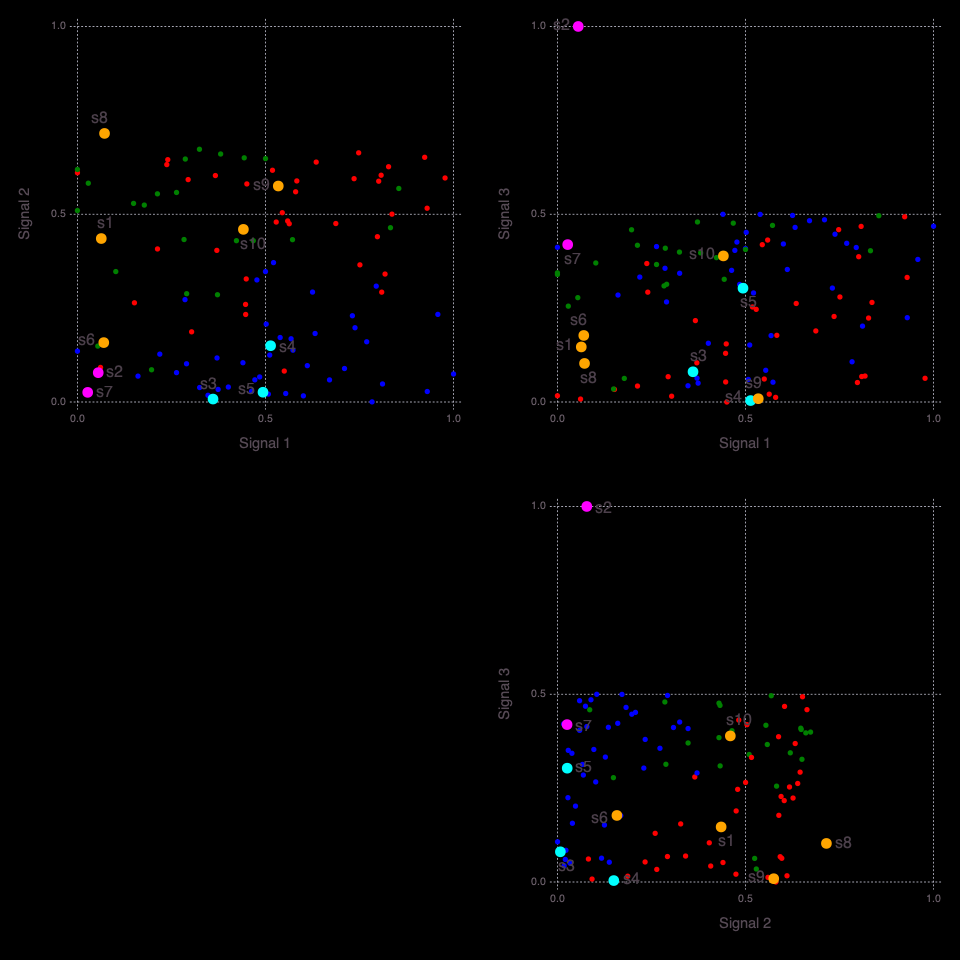

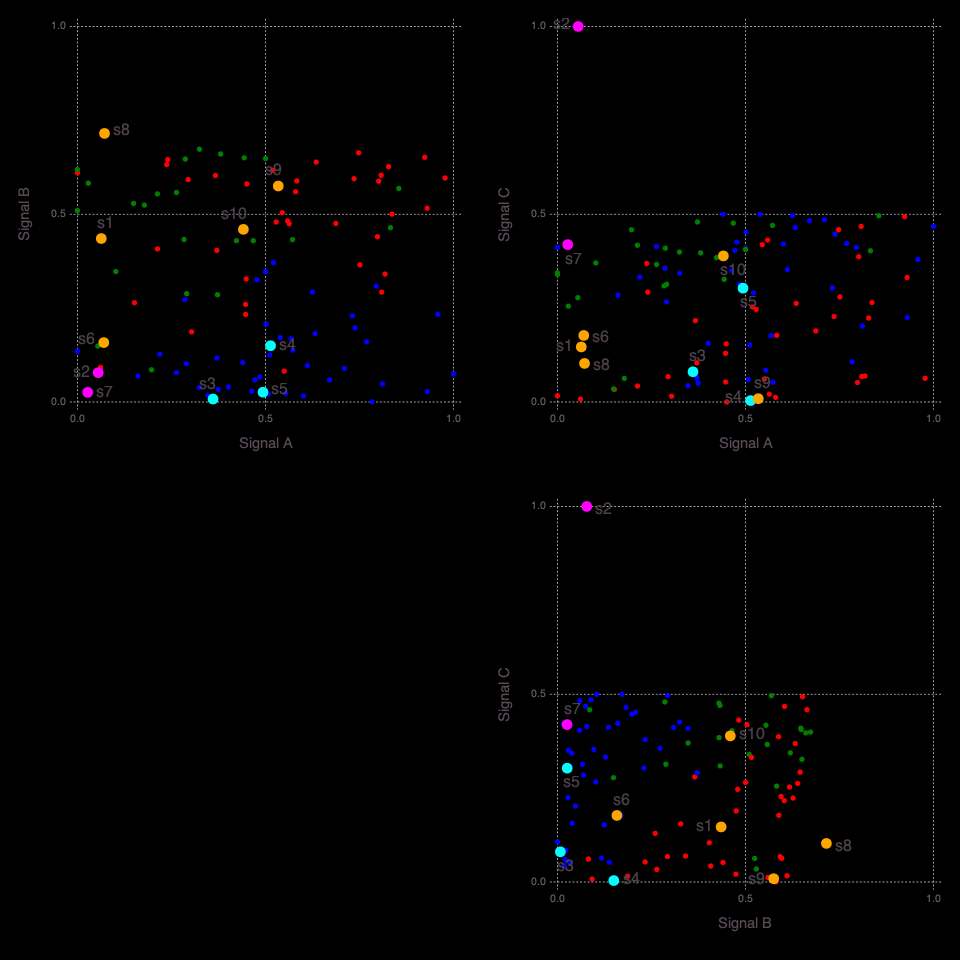

┌ Info: Number of signals: 4
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:205
┌ Info: Sensors (signals=4)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:209
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Hmatrix-4-4_10-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67


2×2 Matrix{Any}:
 "s5"  1.0
 "s3"  0.802067

3×2 Matrix{Any}:
 "s8"  1.0
 "s9"  0.810281
 "s1"  0.60172

3×2 Matrix{Any}:
 "s4"   1.0
 "s10"  0.605222
 "s6"   0.199823

2×2 Matrix{Any}:
 "s2"  1.0
 "s7"  0.401176

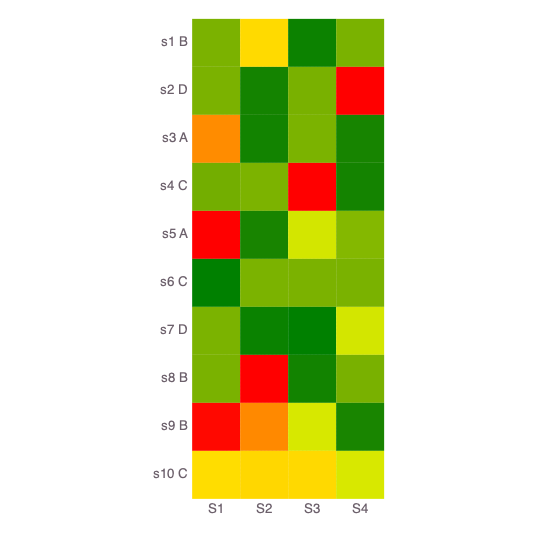

┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: Procedure to find unique signals could not identify a solution ...
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:158
┌ Warning: type Clustering.KmeansResult{Core.Array{Core.Float64,2},Core.Float64,Core.Int64} not present in workspace; reconstructing
└ @ JLD /Users/vvv/.julia/packages/JLD/JHrZe/src/jld_types.jl:697
┌ Info: Robust k-means analysis results are loaded from file ./Wmatrix-4-4_100-1000.jld!
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkCluster.jl:67
┌ Info: Signal D -> A Count: 2
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:316
┌ Info: Sign

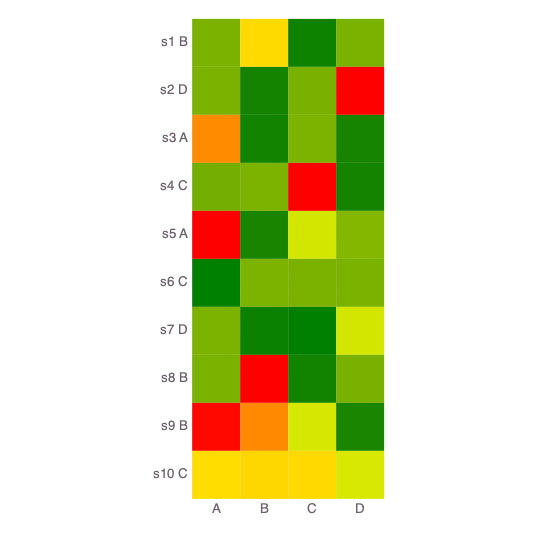

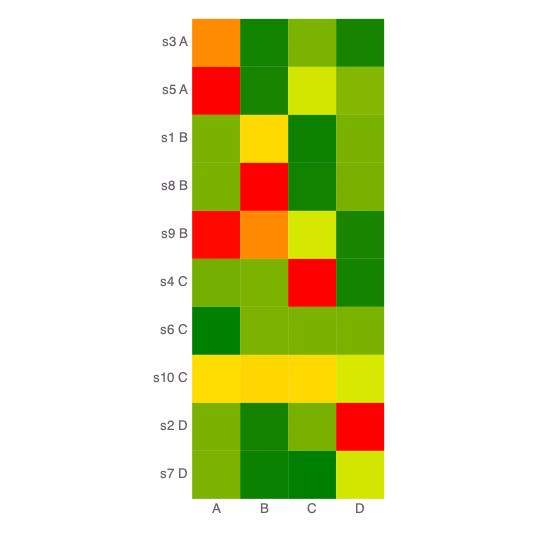

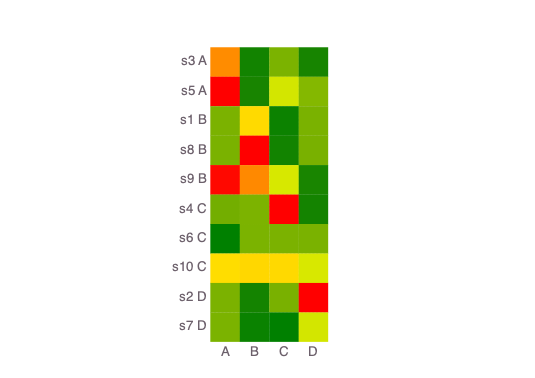

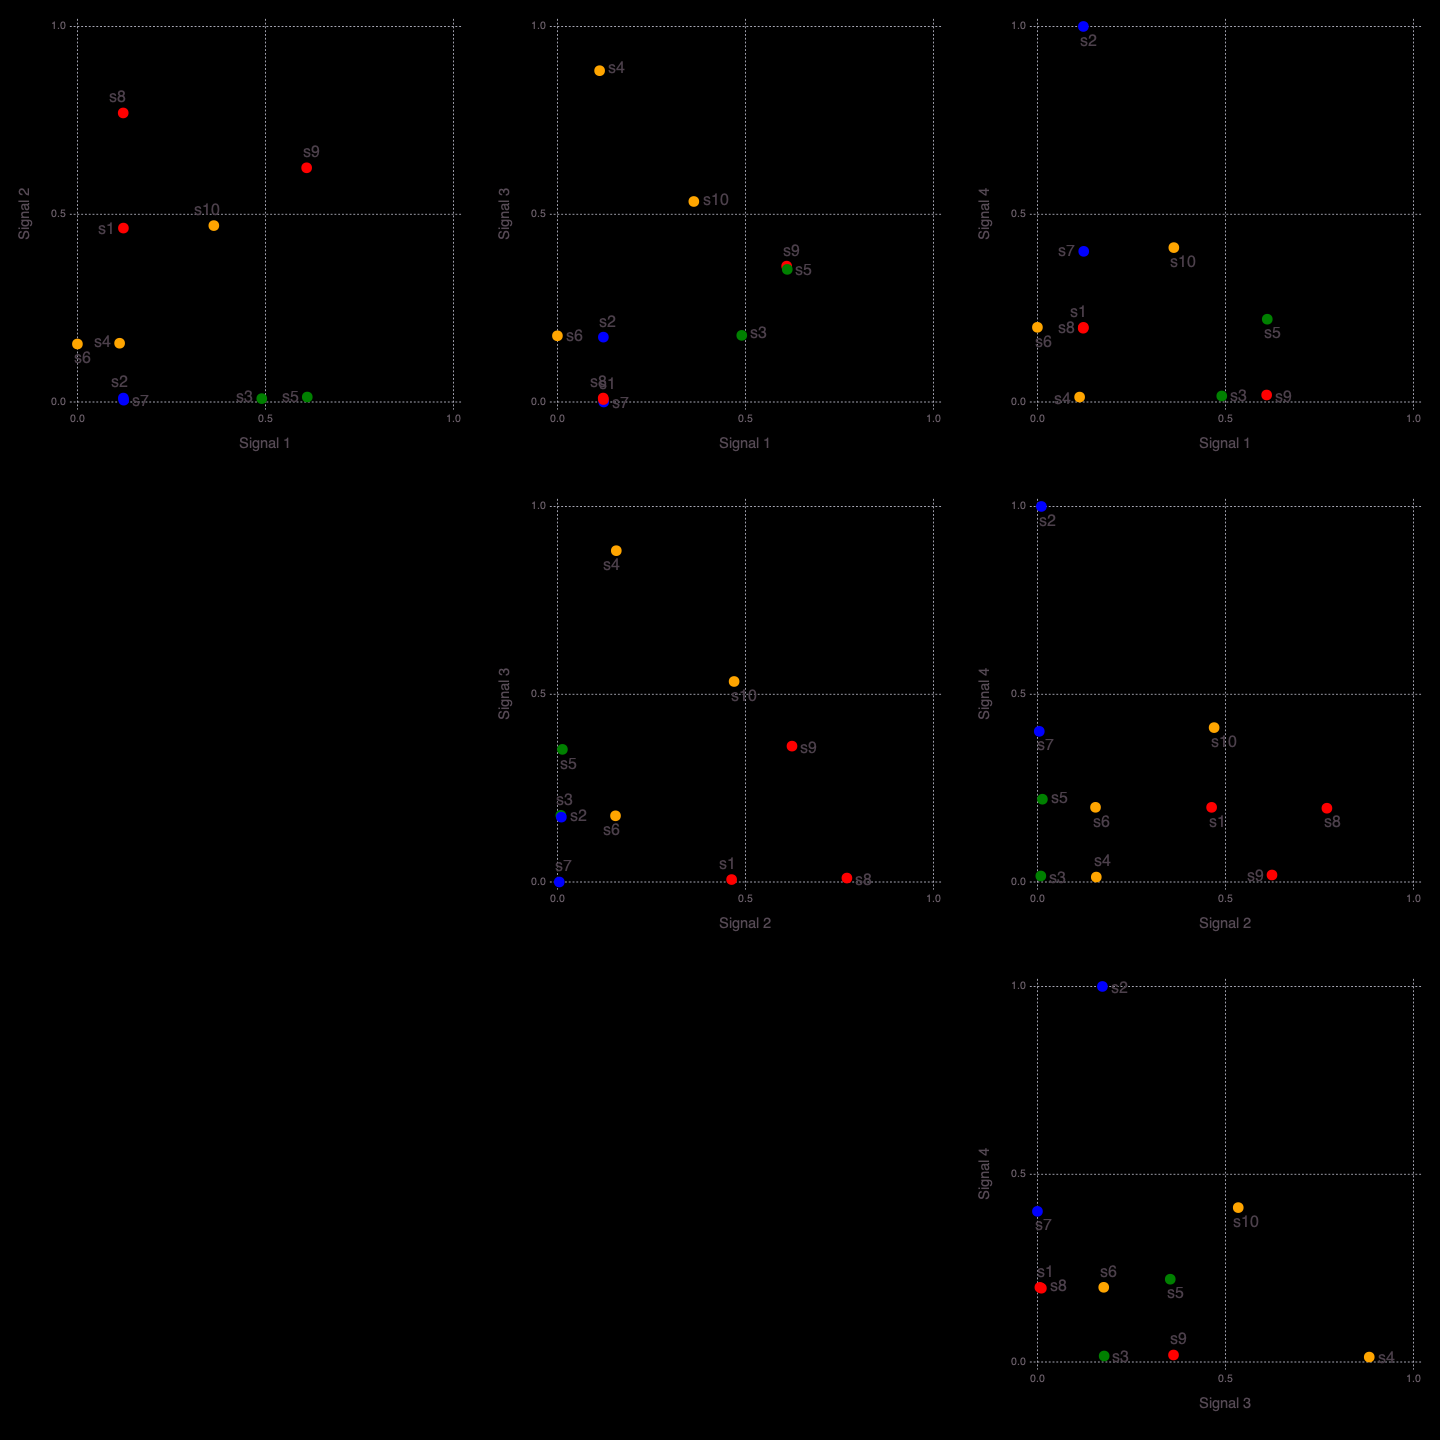

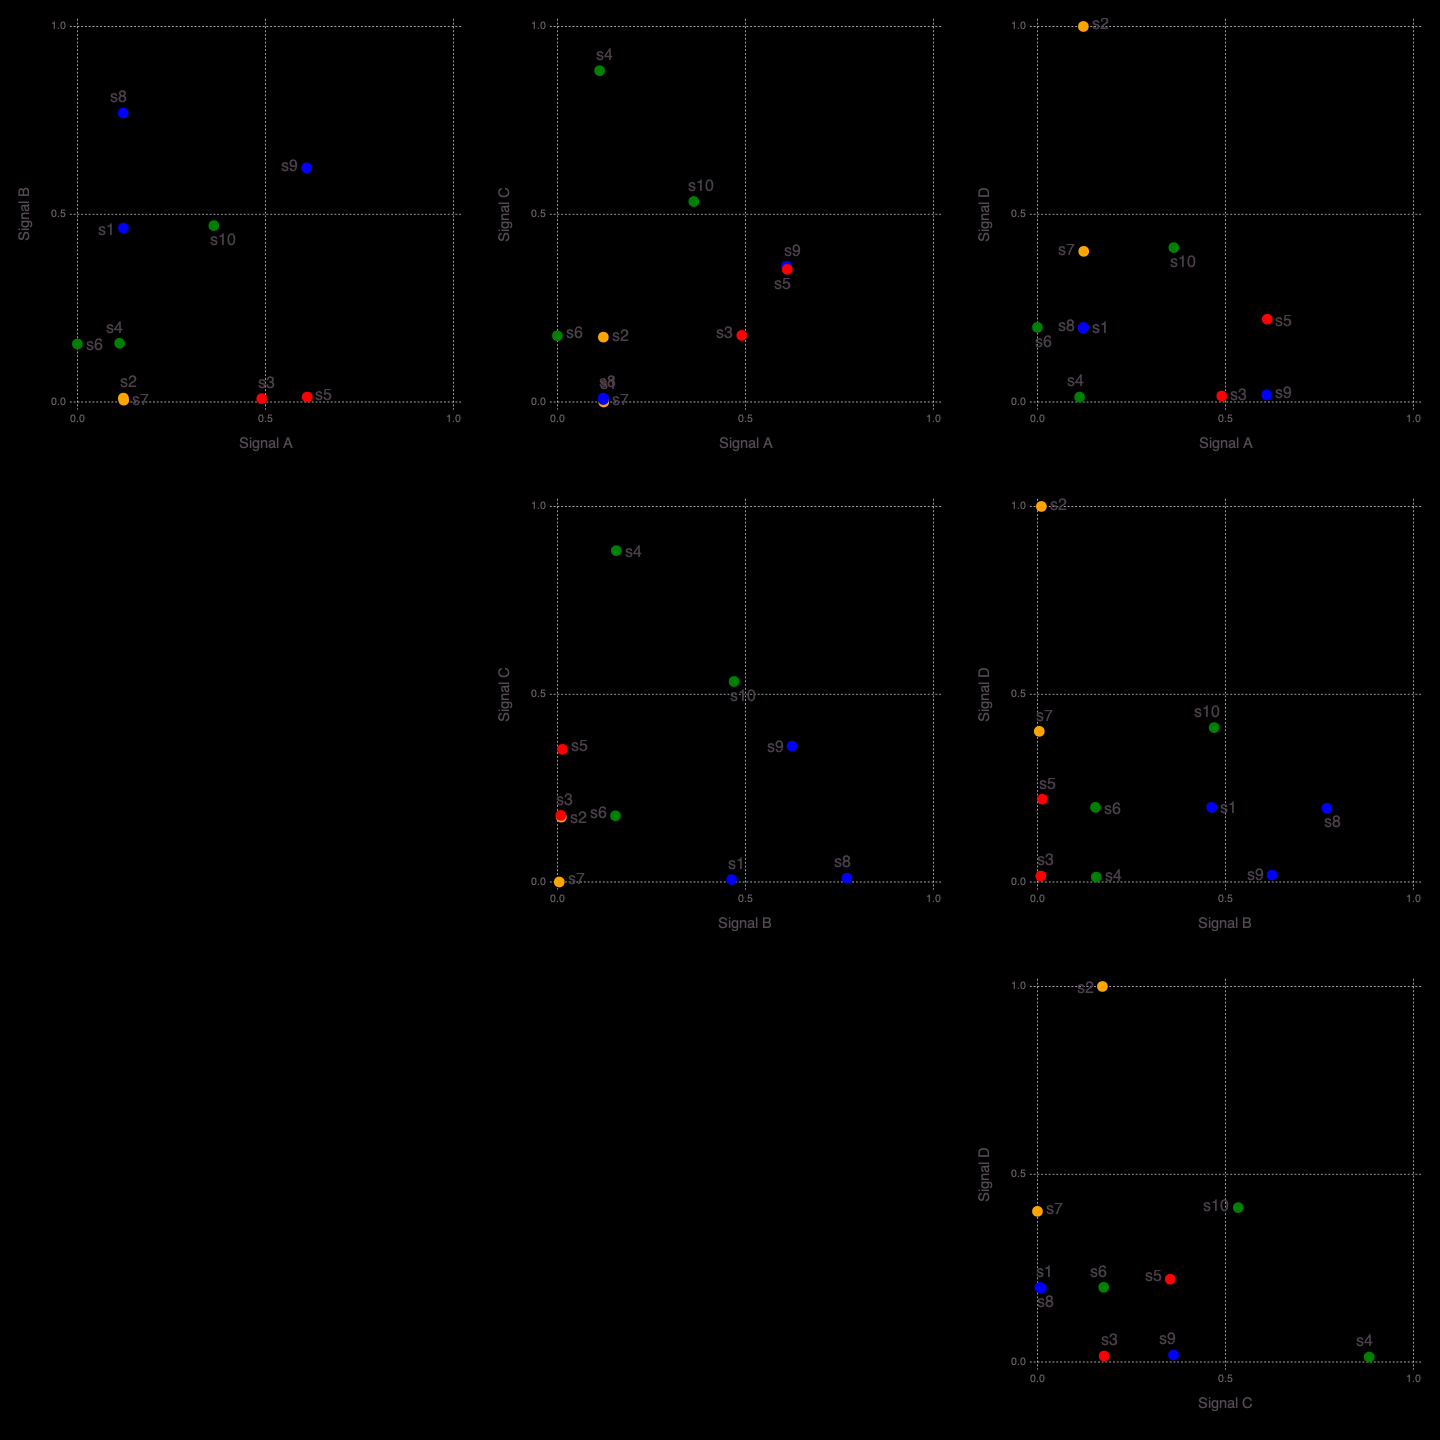

12×2 Matrix{Float64}:
 73.0  0.921292
 48.0  0.920805
  7.0  0.877473
 22.0  0.655249
 23.0  0.608288
 49.0  0.581644
 45.0  0.553796
 34.0  0.302301
  9.0  0.230956
 47.0  0.22555
 10.0  0.118299
 11.0  0.0695206

40×2 Matrix{Float64}:
 41.0  1.0
 16.0  0.999658
 66.0  0.992652
  3.0  0.992084
 28.0  0.99095
 53.0  0.989901
 79.0  0.989034
 78.0  0.982986
 54.0  0.979585
 15.0  0.974543
  ⋮    
 19.0  0.464894
 75.0  0.400071
 57.0  0.3924
 12.0  0.362026
 32.0  0.358336
 37.0  0.33514
 62.0  0.298027
 58.0  0.171558
 99.0  0.15367

21×2 Matrix{Float64}:
 89.0  1.0
  5.0  0.996169
 68.0  0.993815
 26.0  0.984241
 88.0  0.978007
 90.0  0.974038
 67.0  0.966074
  4.0  0.954186
 69.0  0.953466
 91.0  0.918523
  ⋮    
 86.0  0.806738
 65.0  0.800517
  2.0  0.770976
 30.0  0.703892
 51.0  0.697919
 93.0  0.681621
 63.0  0.528743
 95.0  0.3876
 96.0  0.257164

27×2 Matrix{Float64}:
  33.0  1.0
  35.0  0.993739
  36.0  0.99033
  25.0  0.977145
  24.0  0.970044
  21.0  0.938953
  20.0  0.921989
  44.0  0.905292
  46.0  0.879213
  50.0  0.799437
   ⋮    
  74.0  0.234344
  82.0  0.0877105
  83.0  0.0760717
  84.0  0.0648747
  85.0  0.0522789
 100.0  0.0146202
  98.0  0.00610281
  97.0  0.0035143
  94.0  1.57367e-8

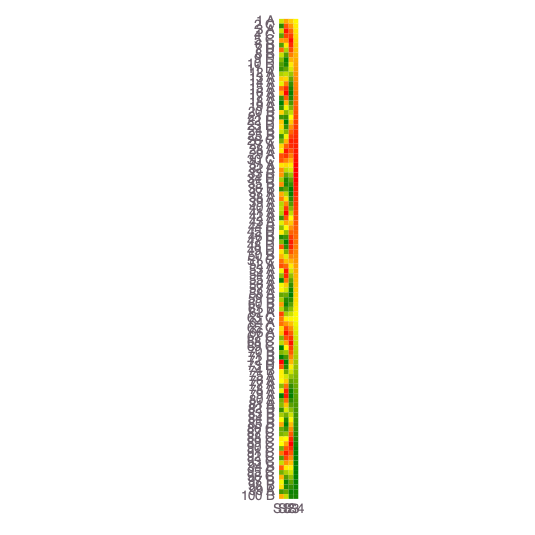

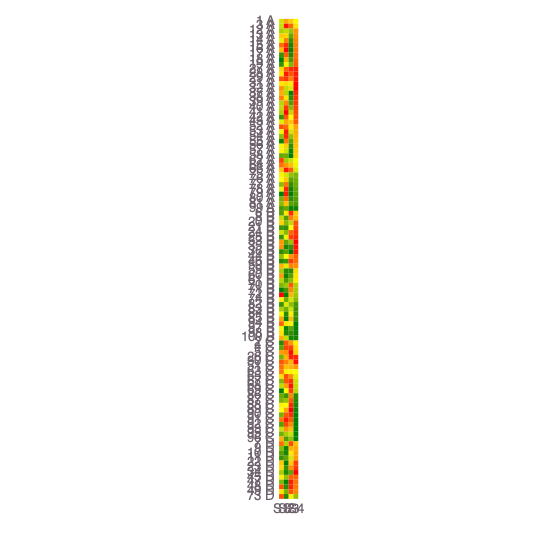

┌ Info: Times (signals=4)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:391
┌ Info: Signal A (S2) Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal B (S4) Count: 27
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal C (S3) Count: 21
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal D (S1) Count: 12
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:404
┌ Info: Signal D -> A Count: 12
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal A -> B Count: 40
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal C -> C Count: 21
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal B -> D Count: 27
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:414
┌ Info: Signal A (remapped k-means clustering)
└ @ NMFk /Users/vvv/.julia/dev/NMFk/src/NMFkPostprocess.jl:429
┌ Info: Signal B (remapped k-means cluste

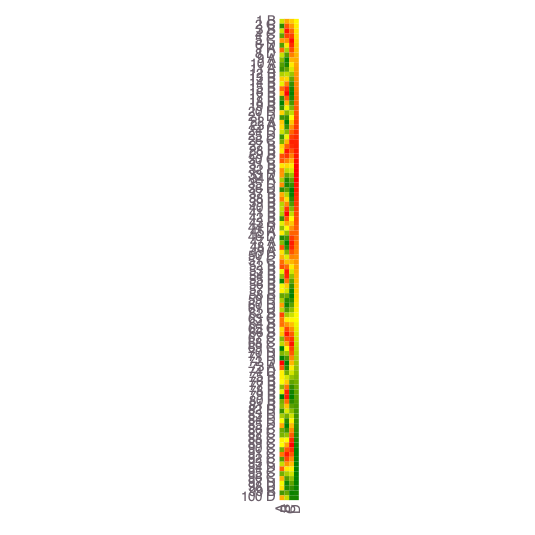

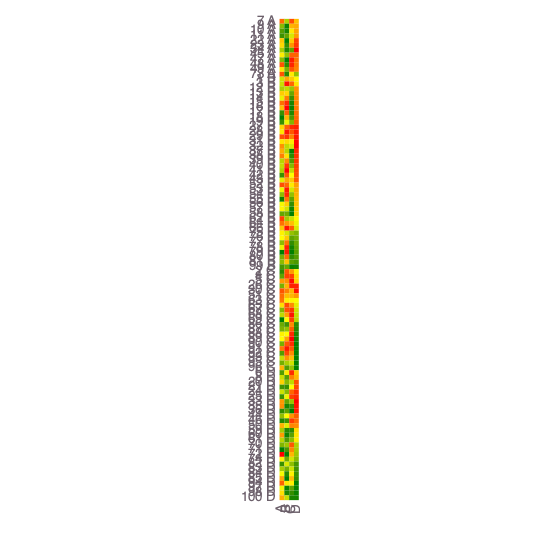

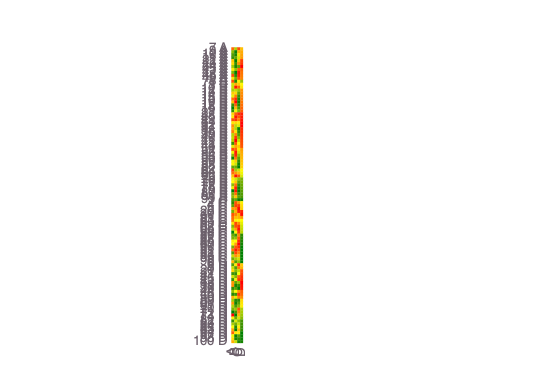

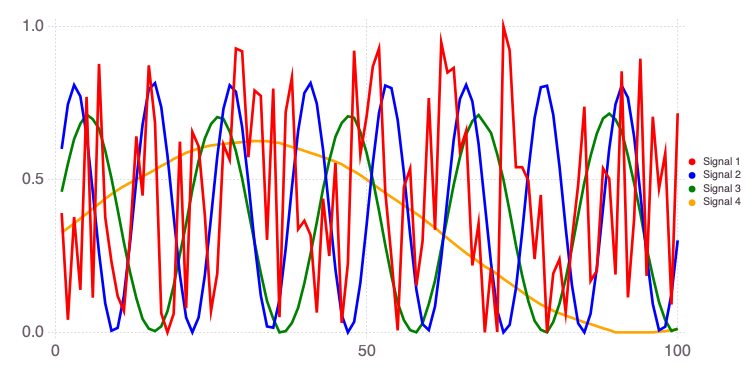

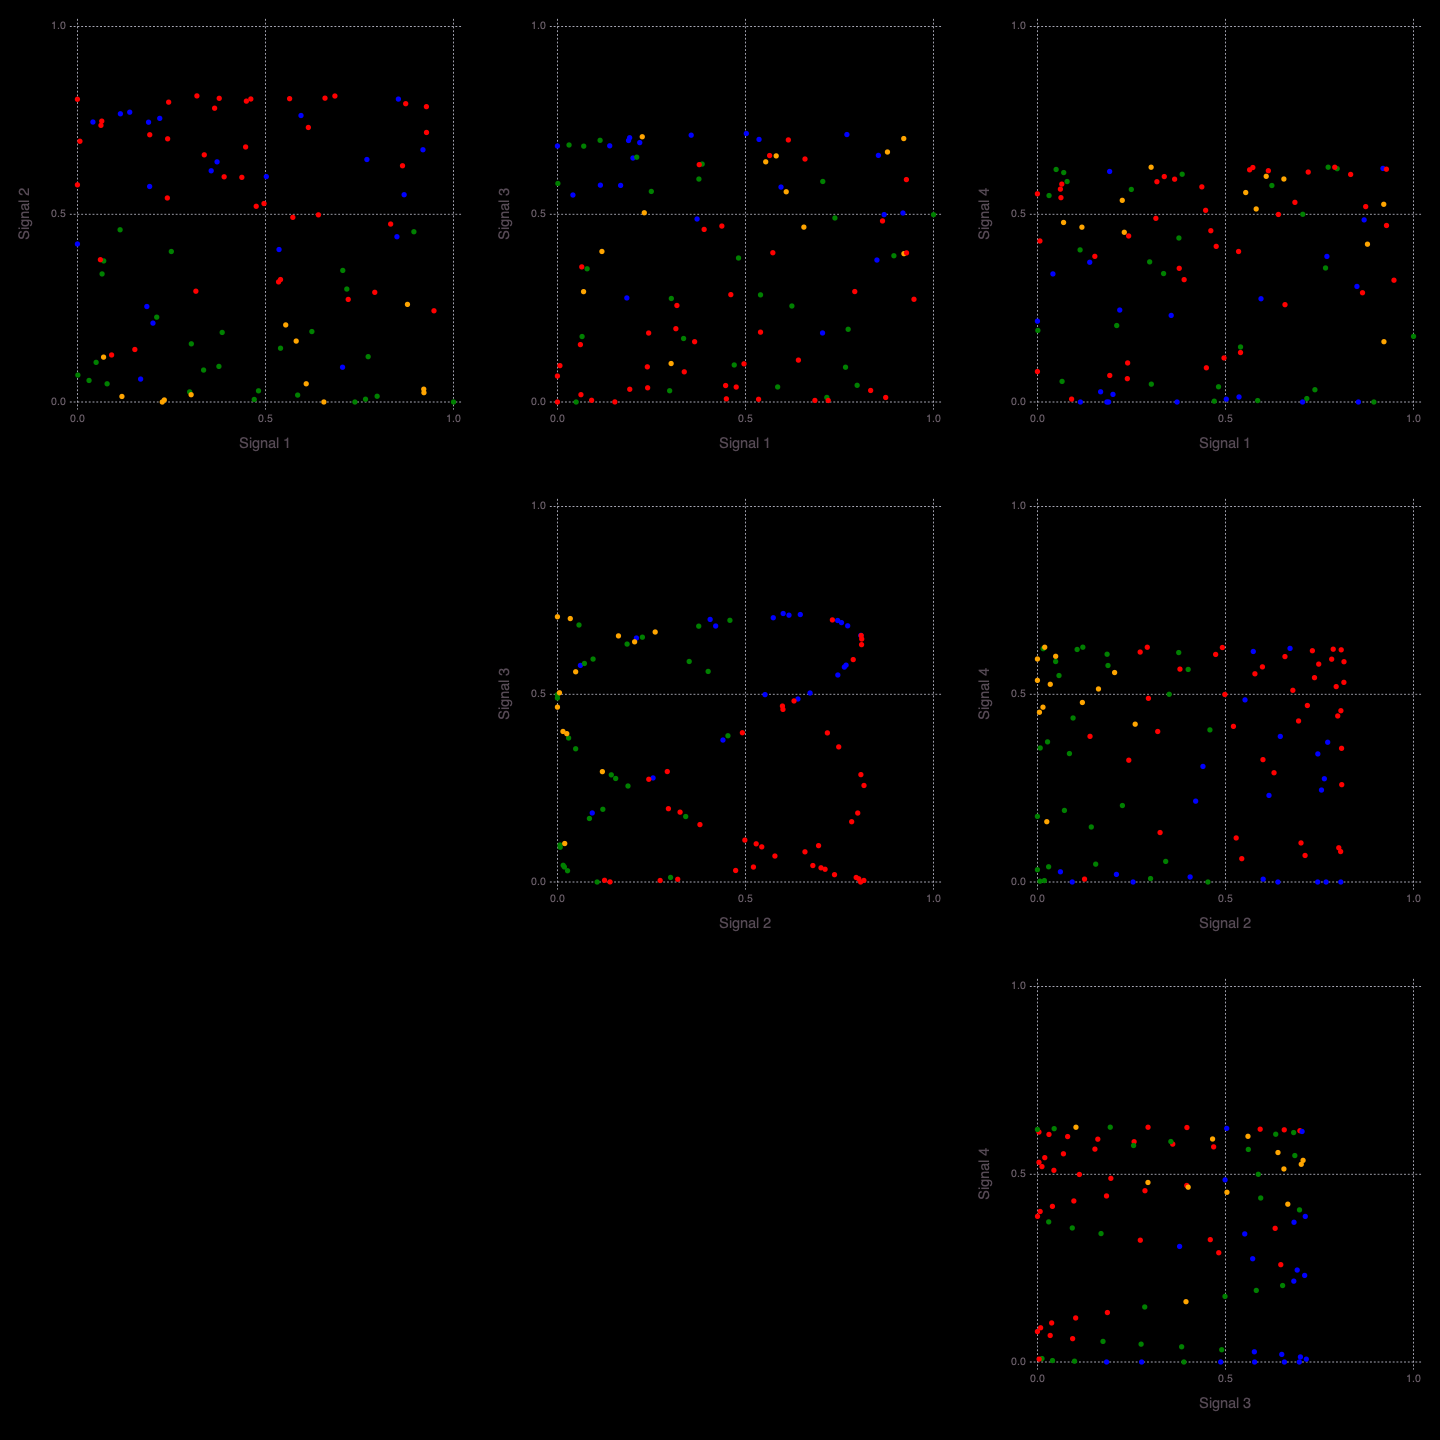

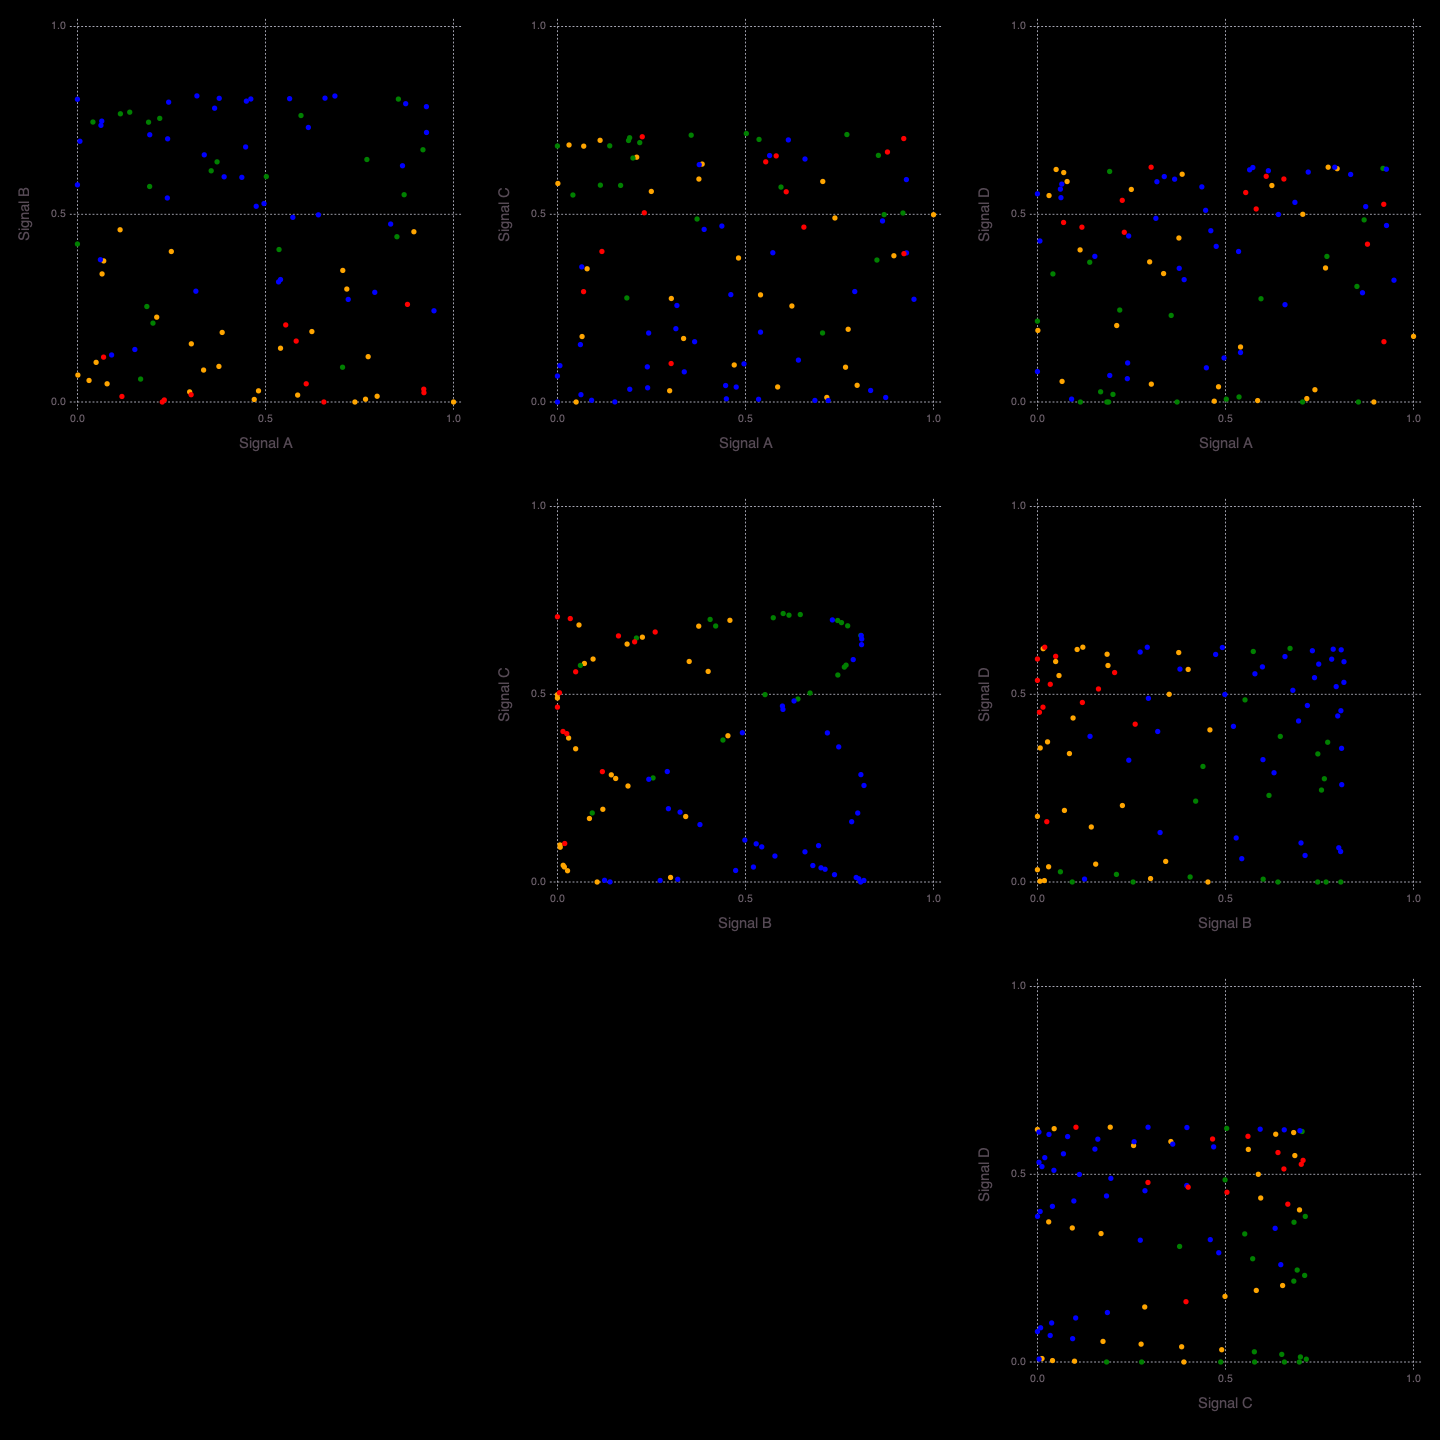

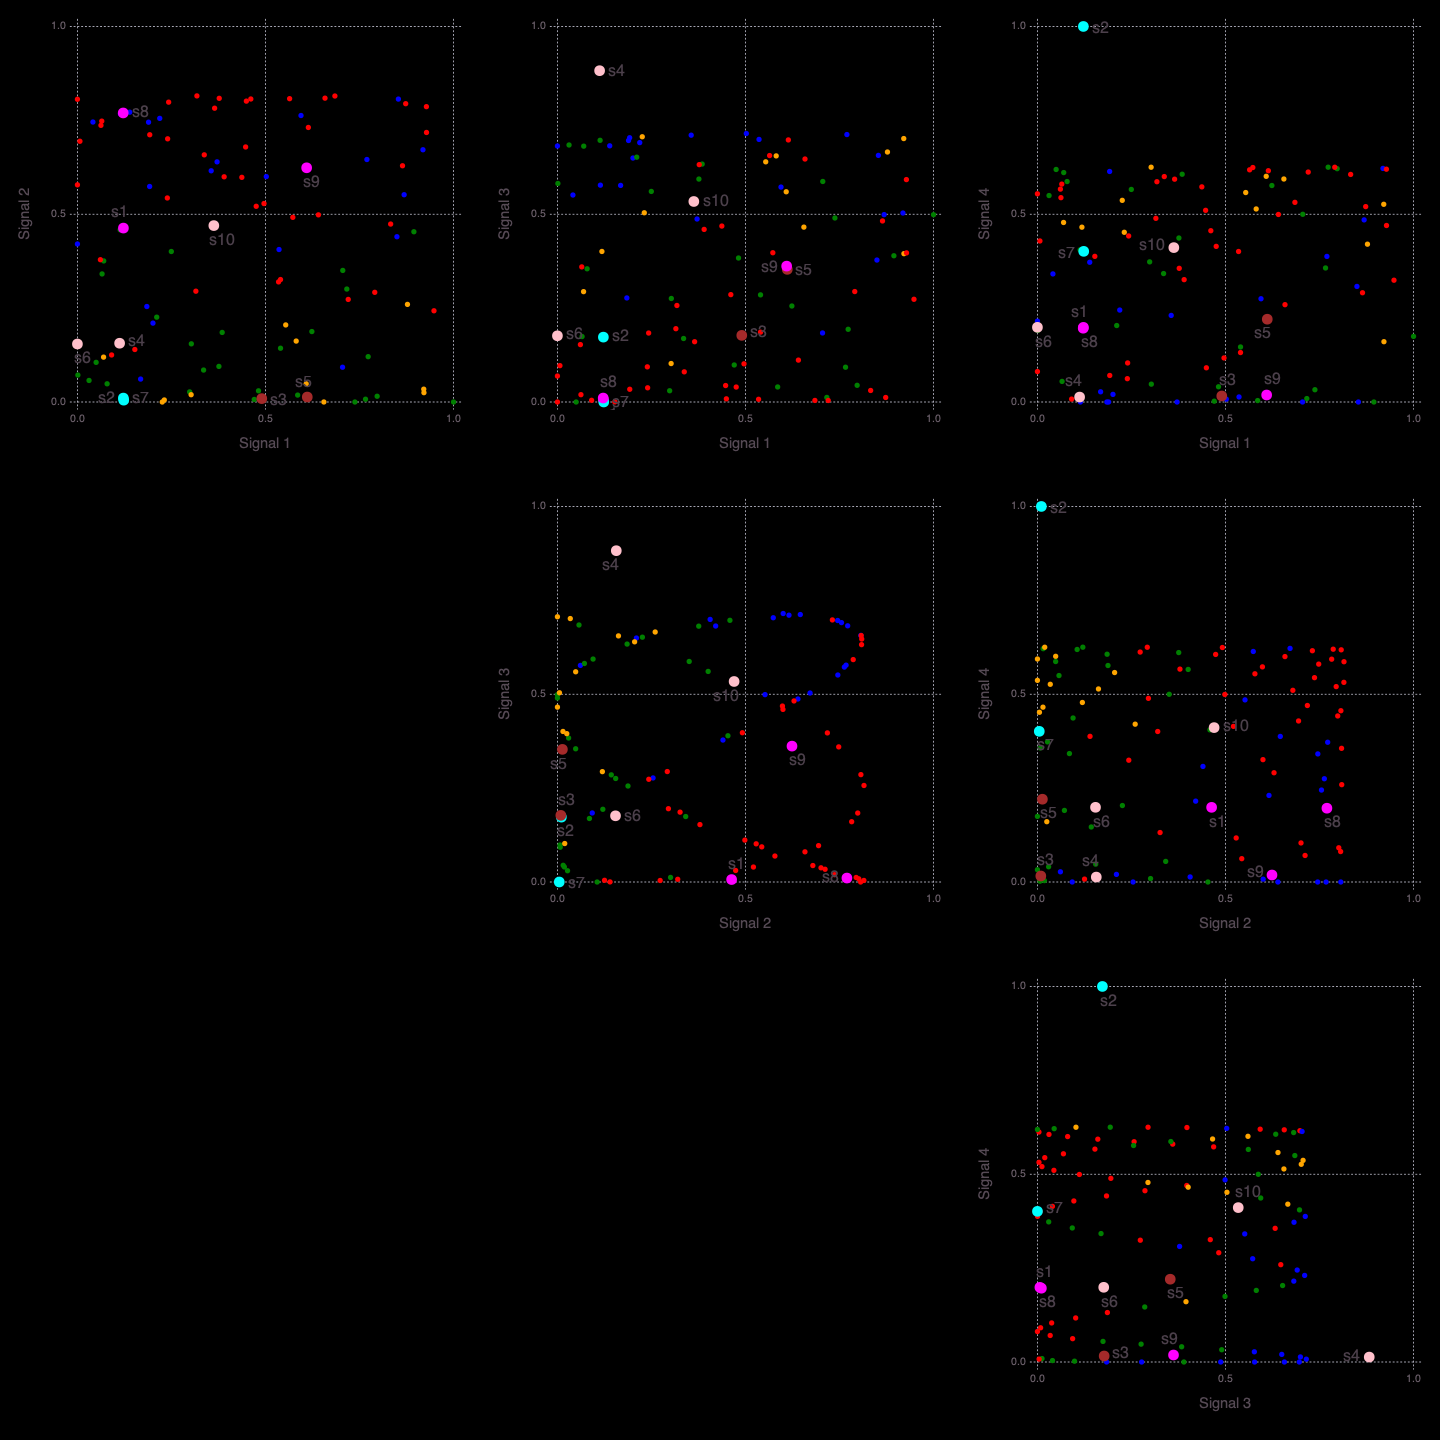

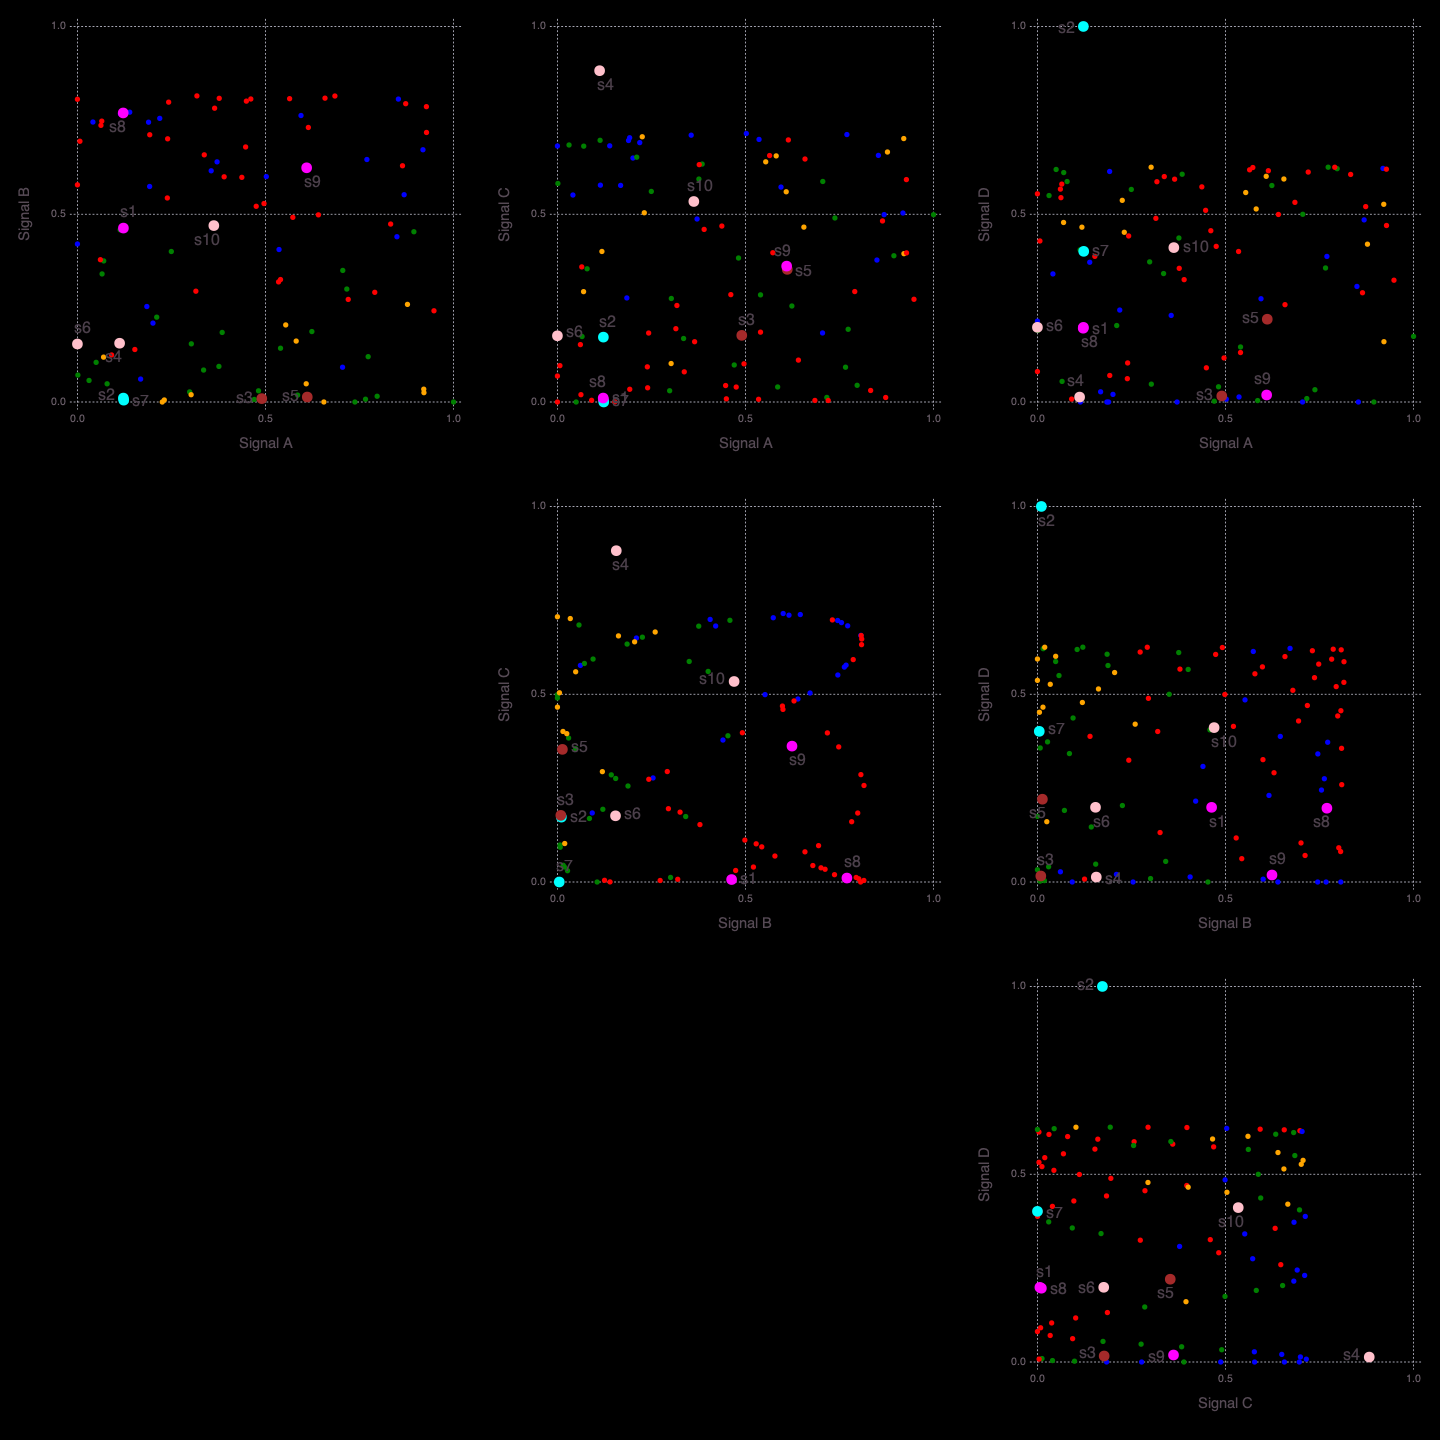

([[1, 2], [1, 2, 3], [1, 2, 3, 4]], [['B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'A'  …  'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'], ['A', 'A', 'A', 'A', 'A', 'C', 'C', 'C', 'C', 'C'  …  'A', 'A', 'A', 'A', 'A', 'A', 'C', 'C', 'A', 'A'], ['B', 'C', 'B', 'C', 'C', 'D', 'A', 'D', 'A', 'A'  …  'C', 'C', 'C', 'D', 'C', 'C', 'D', 'D', 'B', 'D']], [['B', 'A', 'B', 'B', 'B', 'B', 'A', 'B', 'B', 'B'], ['B', 'C', 'A', 'A', 'A', 'B', 'C', 'B', 'B', 'B'], ['B', 'D', 'A', 'C', 'A', 'C', 'D', 'B', 'B', 'C']])

In [16]:
NMFk.clusterresults(NMFk.getks(nkrange, robustness[nkrange]), We, He, collect(1:100), "s" .* string.(collect(1:10)); Wcasefilename="times", Hcasefilename="sensors", plottimeseries=:W, biplotcolor=:WH, sortmag=false, biplotlabel=:H, point_size_nolabel=2Gadfly.pt, point_size_label=4Gadfly.pt)

The code above perform analyses of all the acceptable solutions.

These are solutions with number of extracted features equal to 2, 3, and 4.

The solution with 4 features is the optimal one.

The solutions for 2 and 3 features are underfitting but informative as well.

Extracted features based on the solutions for 2, 3, and 4 signals look like this:

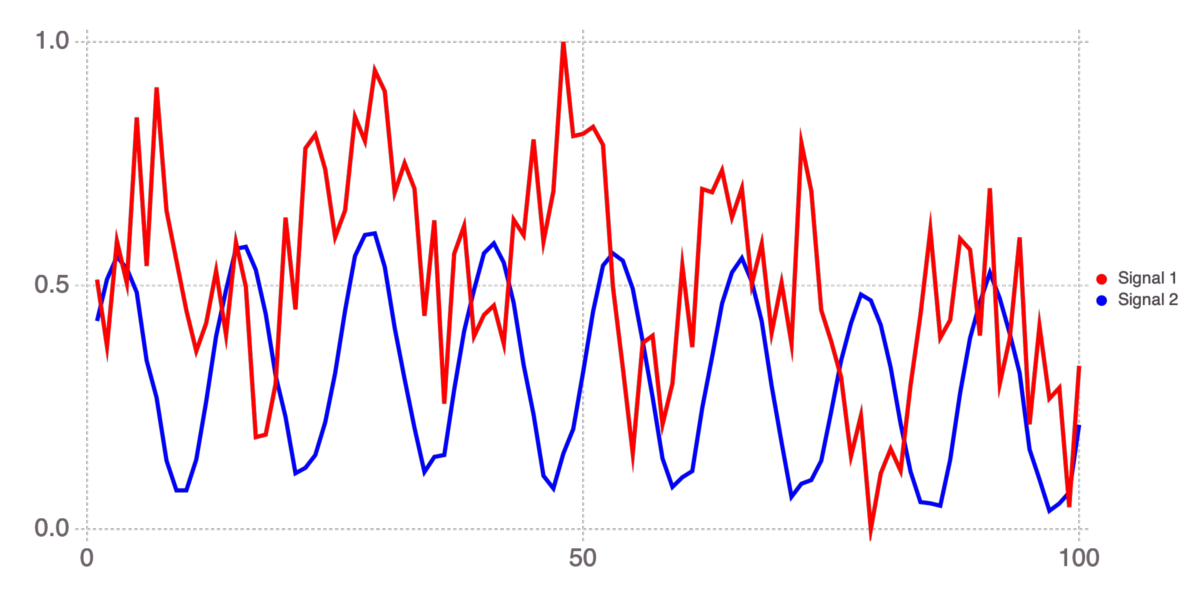

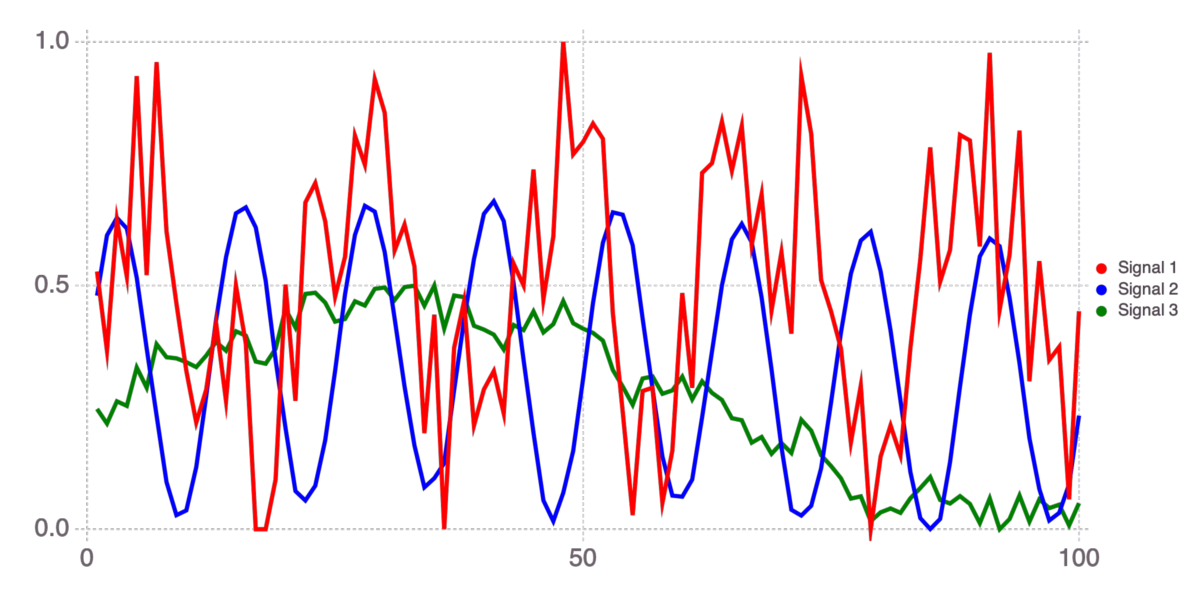

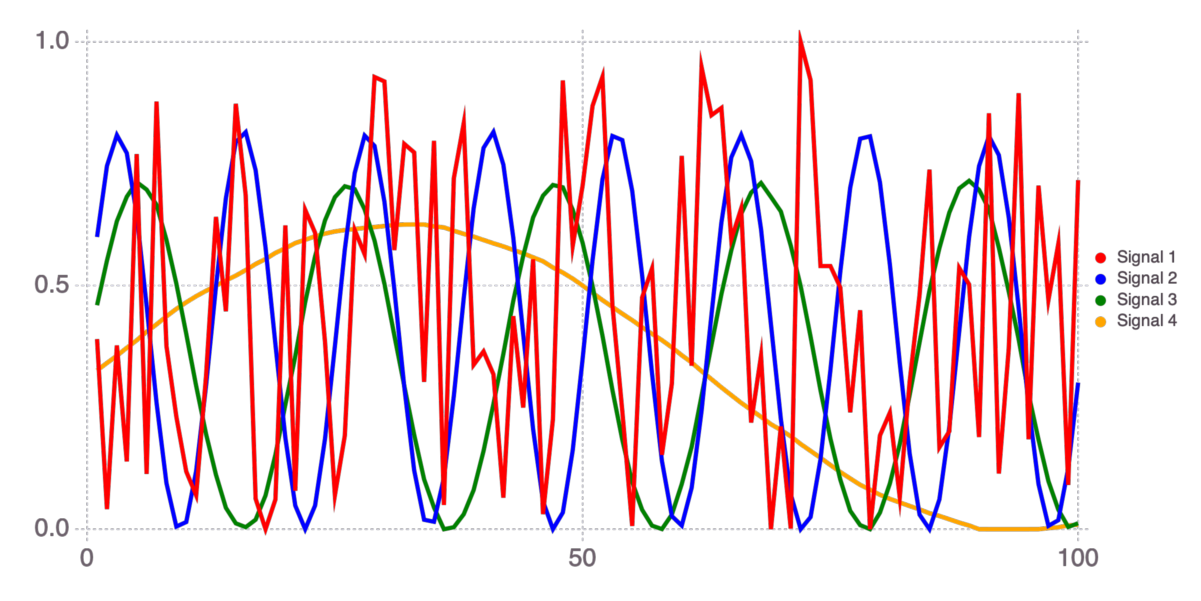

In [17]:
for i = 2:4
	Mads.display("times-$i-timeseries.png")
end

The 10 sensors are grouped into 4 groups.

The sensor grouping is based on which of the 4 signals are mostly detected by the 4 sensors.

The sensor grouping is listed below:

In [18]:
Mads.display("sensors-4-groups.txt")

Signal A (S1)
s5 	1.0
s3 	0.802

Signal B (S2)
s8 	1.0
s9 	0.81
s1 	0.602

Signal C (S3)
s4 	1.0
s10	0.605
s6 	0.2

Signal D (S4)
s2 	1.0
s7 	0.401



This grouping is based on analyses of the attribute matrix `H` presented below.

The grouping process tries to pick up the most important signal observed by each sensor.

However, there are challenges when more than one signal is present.

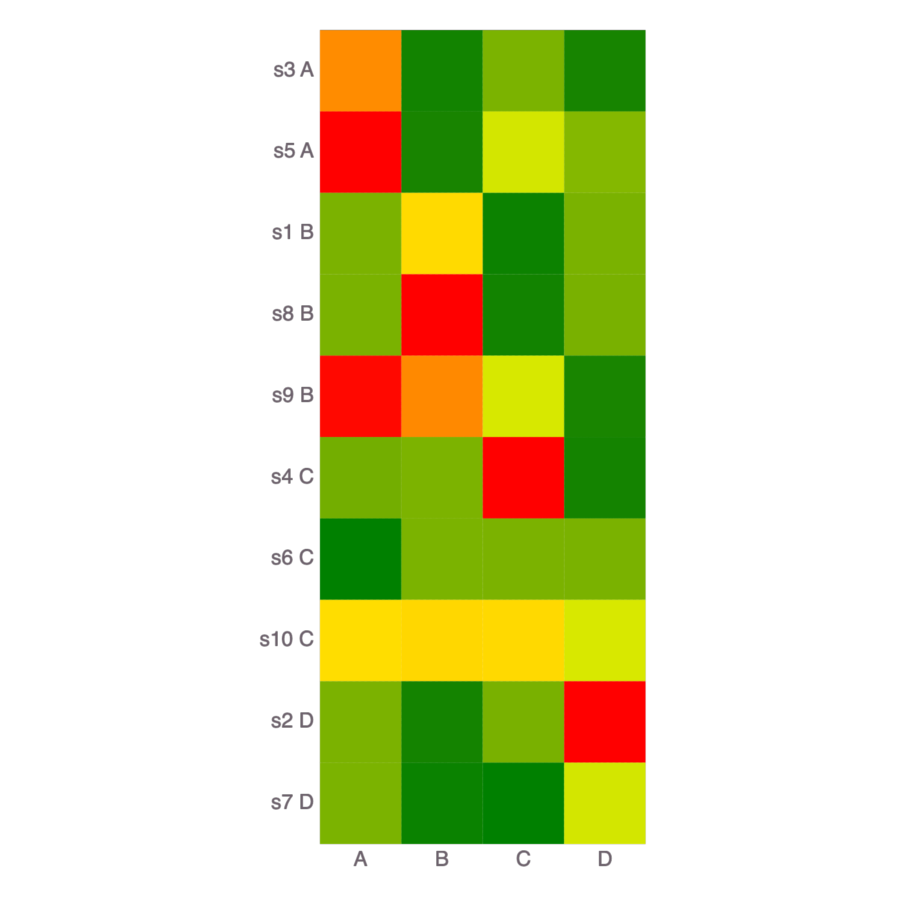

In [19]:
Mads.display("sensors-4-labeled-sorted.png")

The clustering of the sensors into groups at the different levels of clsutering is visualized below:

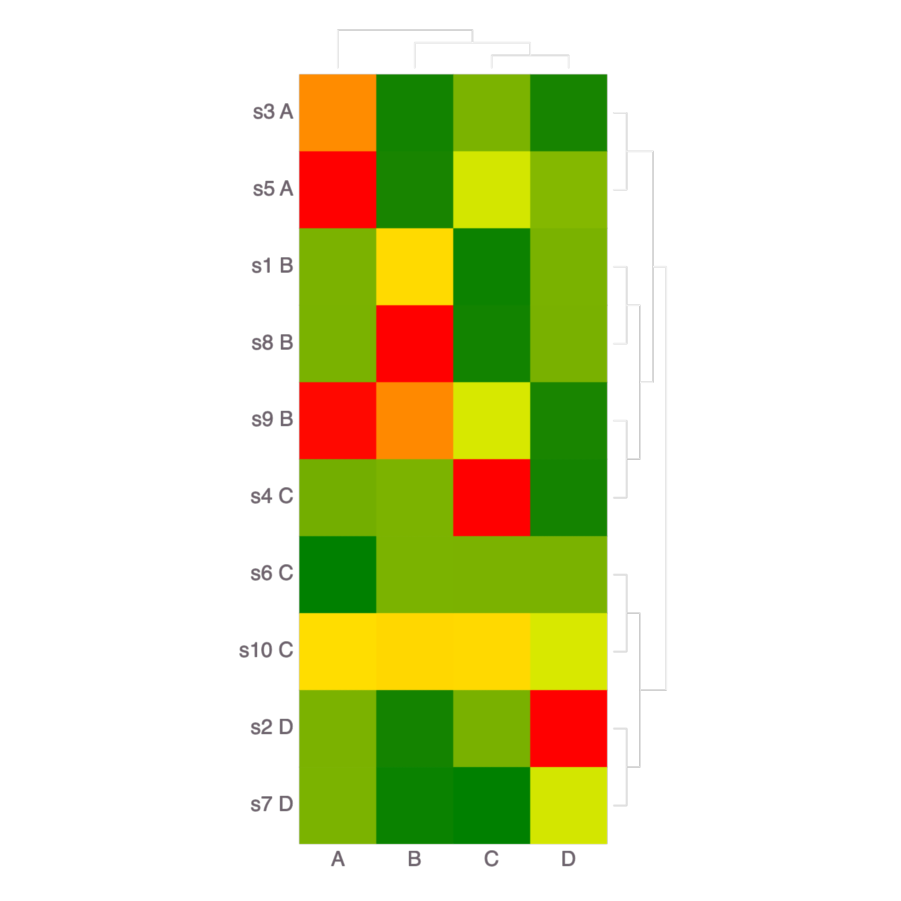

In [20]:
Mads.display("sensors-4-labeled-sorted-dendrogram.png")


The biplots below show how the 4 extracted features are projecting the sensors and the timeseries data.

Here, the features are viewed as basis vectors spanning the sensor/time space.

Sensors located along the basis vectors (i.e., plot axes) are the most informative to characterize the data.

Temporal measurements along the plot axes are also the most important to represent the observed processes.

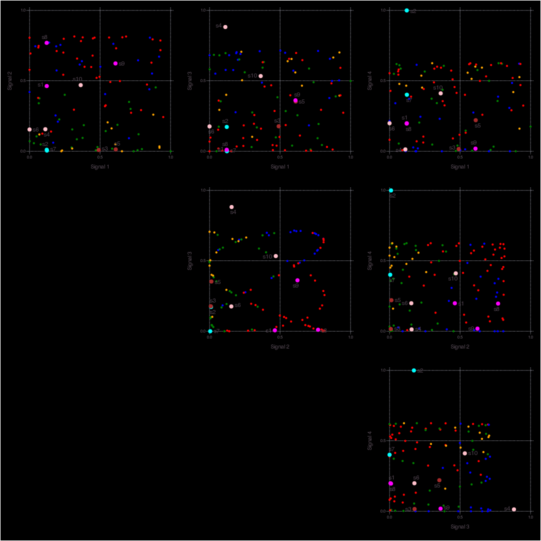

In [21]:
Mads.display("all-4-biplots-original.pdf")